In [17]:
# from google.colab import drive
# drive.mount('/content/drive')

# 0. Preamble

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statistics
from sklearn.linear_model import LinearRegression
import os
import sqlite3

In [19]:
# notebook_path = '/content/drive/MyDrive/Colab_Notebooks/ISER/code/'
# os.chdir(notebook_path)

In this section, I import the dataset located in the raw data folder and clean the column names.

In [20]:
data = pd.read_csv("../raw_data/global_crisis_data_country.csv", encoding='unicode_escape')

In [21]:
print(data.shape)
data.head()

(15191, 27)


,Case,CC3,Country,Year,Banking Crisis,Banking_Crisis_Notes,Systemic Crisis,Gold Standard,exch_usd,exch_usd_alt1,...,Domestic_Debt_ Notes/Sources,"SOVEREIGN EXTERNAL DEBT 1: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom and post-1975 defaults on Official External Creditors","SOVEREIGN EXTERNAL DEBT 2: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom but includes post-1975 defaults on Official External Creditors",Defaults_External_Notes,GDP_Weighted_default,<,"Inflation, Annual percentages of average consumer prices",Independence,Currency Crises,Inflation Crises
0,NaN,NaN,NaN,NaN,x,NaN,x,x,NaN,NaN,...,NaN,x,NaN,NaN,x,x,NaN,x,x,x
1,1.0,DZA,Algeria,1800.0,0,NaN,0,0,NaN,NaN,...,NaN,0,0.0,NaN,0,NaN,NaN,0,0,0
2,1.0,DZA,Algeria,1801.0,0,NaN,0,0,NaN,NaN,...,NaN,0,0.0,NaN,0,NaN,NaN,0,0,0
3,1.0,DZA,Algeria,1802.0,0,NaN,0,0,NaN,NaN,...,NaN,0,0.0,NaN,0,NaN,NaN,0,0,0
4,1.0,DZA,Algeria,1803.0,0,NaN,0,0,NaN,NaN,...,NaN,0,0.0,NaN,0,NaN,NaN,0,0,0


In [22]:
data.columns

Index(['Case', 'CC3', 'Country', 'Year', 'Banking Crisis ',
       'Banking_Crisis_Notes', 'Systemic Crisis', 'Gold Standard', 'exch_usd',
       'exch_usd_alt1', 'exch_usd_alt2', 'exch_usd_alt3', 'conversion_notes',
       'national currency', 'exch_primary source code', 'exch_sources',
       'Domestic_Debt_In_Default', 'Domestic_Debt_ Notes/Sources',
       'SOVEREIGN EXTERNAL DEBT 1: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom and post-1975 defaults on Official External Creditors',
       'SOVEREIGN EXTERNAL DEBT 2: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom but includes post-1975 defaults on Official External Creditors',
       'Defaults_External_Notes', 'GDP_Weighted_default', '<',
       'Inflation, Annual percentages of average consumer prices',
       'Independence', 'Currency Crises', 'Inflation Crises'],
      dtype='object')

In [23]:
data.drop(0, inplace = True)
data.shape

(15190, 27)

In [24]:
data.rename(columns={'Banking Crisis ':'banking_crisis',
                    'Systemic Crisis':'systemic_crisis',
                    'Banking_Crisis_Notes':'notes',
                    'Gold Standard':'gold_standard',
                    'SOVEREIGN EXTERNAL DEBT 1: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom and post-1975 defaults on Official External Creditors': 'sovereign_external_debt_1',
                    'SOVEREIGN EXTERNAL DEBT 2: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom but includes post-1975 defaults on Official External Creditors': 'sovereign_external_debt_2',
                    'Inflation, Annual percentages of average consumer prices':'annual_inflation'},
            inplace = True)
data['Year'] = data['Year'].astype(int)

In [25]:
data['banking_crisis'] = pd.to_numeric(data['banking_crisis'], errors='coerce')
data['systemic_crisis'] = pd.to_numeric(data['systemic_crisis'], errors='coerce')
data['annual_inflation'] = pd.to_numeric(data['annual_inflation'], errors='coerce')

In [26]:
data.dtypes

Case                            float64
CC3                              object
Country                          object
Year                              int64
banking_crisis                  float64
notes                            object
systemic_crisis                 float64
gold_standard                    object
exch_usd                         object
exch_usd_alt1                   float64
exch_usd_alt2                    object
exch_usd_alt3                    object
conversion_notes                 object
national currency                object
exch_primary source code         object
exch_sources                     object
Domestic_Debt_In_Default         object
Domestic_Debt_ Notes/Sources     object
sovereign_external_debt_1        object
sovereign_external_debt_2       float64
Defaults_External_Notes          object
GDP_Weighted_default             object
<                                object
annual_inflation                float64
Independence                     object


# 1. Description of the "Global Crises Data by Country" dataset

## 1.1 Get the number of crisis per country

In [27]:
nb_countries = data["Country"].nunique()
min_year = data["Year"].min()
max_year = data["Year"].max()
nb_observations = max_year - min_year +1
print(f"There are data of {nb_countries} countries in the dataset from {min_year} to {max_year}.")

There are data of 70 countries in the dataset from 1800 to 2016.


We are interested in the number of shocks each country encountered during the period. <br>
Let's try to count the number of banking crisis and systemic crisis for each country.

In [28]:
banking_crisis_per_country = data.groupby('Country')['banking_crisis'].sum().astype(int)
systemic_crisis_per_country = data.groupby('Country')['systemic_crisis'].sum().astype(int)

Note: In the data, a banking crisis and a systemic crisis can be recorded the same year.

In [175]:
results = pd.DataFrame({
                     'banking_crisis_number': banking_crisis_per_country,
                     'systemic_crisis_number': systemic_crisis_per_country
                     })
results.sort_values(by='banking_crisis_number', ascending=False, inplace = True)
results.head(60)

,banking_crisis_number,systemic_crisis_number
Country,,
United States,33,20
United Kingdom,33,20
Spain,30,13
France,26,15
Italy,26,7
Japan,24,5
Netherlands,23,23
Denmark,22,8
Sweden,21,11


In [30]:
results.describe().round(1)

,banking_crisis_number,systemic_crisis_number
count,70.0,70.0
mean,11.5,8.1
std,7.6,5.7
min,0.0,0.0
25%,6.2,4.0
50%,11.0,7.0
75%,15.0,11.8
max,33.0,23.0


## 1.2 Extract per country data

* Data per country

In [31]:
# USA data
USA_data = data[data["CC3"]=='USA']
# UK data
UK_data = data[data["CC3"]=='GBR']
#France data
FRA_data = data[data["CC3"]=='FRA']
# Japan data
JPN_data = data[data["CC3"]=='JPN']

* Data for group of countries

In [32]:
countries_selected = ['FRA',
                      'GBR',
                      'USA',
                      'ITA',
                      'DEU',
                      'CAN',
                      'ESP']
G7_data = data[data["CC3"].isin(countries_selected)]

# 2. Estimating the inflation response to liquidity shocks - focus on the USA

## 2.2 How to record crisis in the US history?

In [33]:
banking_crisis_years = USA_data[USA_data['banking_crisis'] == 1]['Year'].tolist()
print(f'{len(banking_crisis_years)} banking crisis are recorded in the US history.')

33 banking crisis are recorded in the US history.


In [34]:
systemic_crisis_years = USA_data[USA_data['systemic_crisis'] == 1]['Year'].tolist()
print(f'{len(systemic_crisis_years)} systemic crisis are recorded in the US history.')

20 systemic crisis are recorded in the US history.


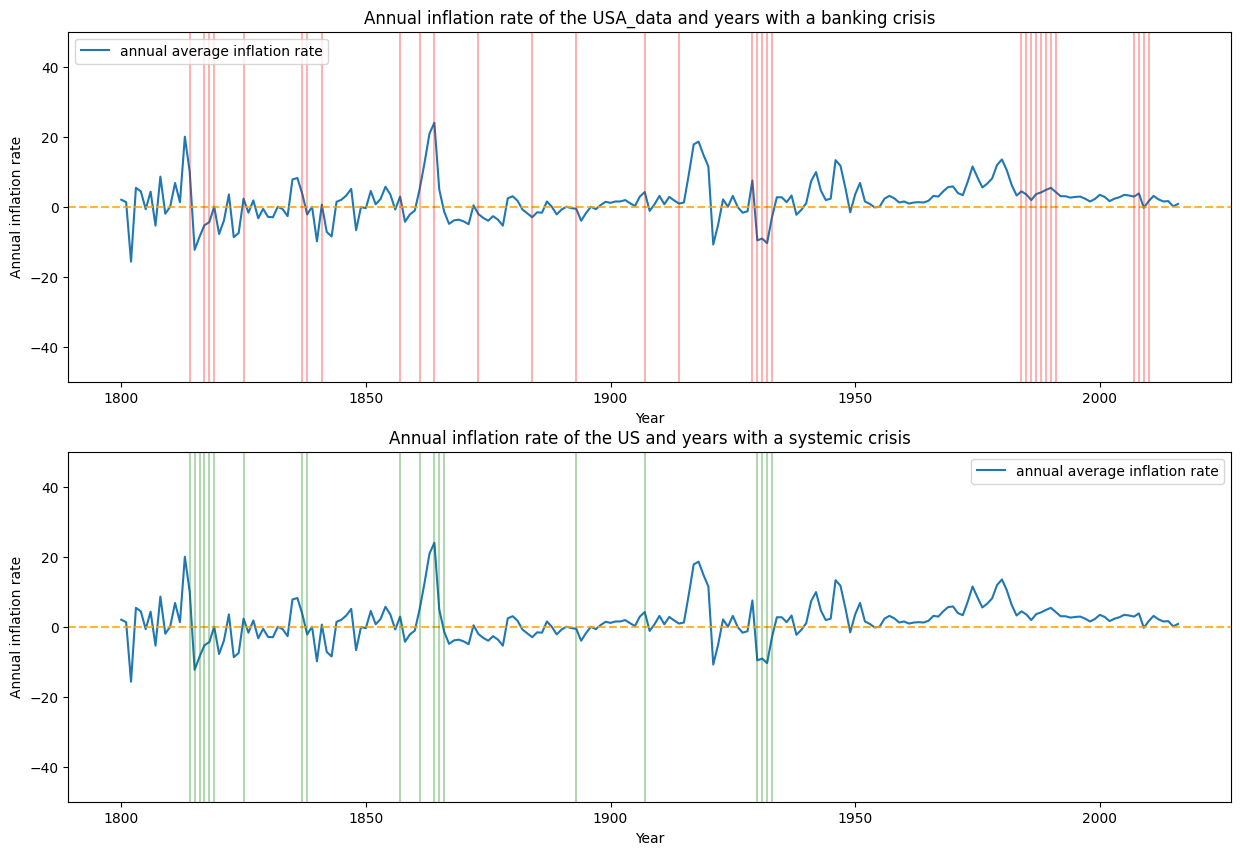

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(15,10))

#Plot the inflation rate with banking crisis as red vertical lines
sns.lineplot(x=USA_data['Year'], y=USA_data['annual_inflation'], label = 'annual average inflation rate', ax=axs[0])

axs[0].axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

for year in banking_crisis_years:
    axs[0].axvline(x=year, color='red', linestyle='-', label='Crisis Period', alpha = 0.3,)

axs[0].set_ylim(-50, 50)

axs[0].set_title('Annual inflation rate of the USA_data and years with a banking crisis')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Annual inflation rate')

#Plot the inflation rate with systemic crisis as green vertical lines
sns.lineplot(x=USA_data['Year'], y=USA_data['annual_inflation'], label = 'annual average inflation rate', ax=axs[1])

axs[1].axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

for year in systemic_crisis_years:
    axs[1].axvline(x=year, color='green', linestyle='-', label='Systemic crisis Period', alpha = 0.3)

axs[1].set_ylim(-50, 50)

axs[1].set_title('Annual inflation rate of the US and years with a systemic crisis')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Annual inflation rate')

plt.savefig('../figures/banking_crisis_overview.png')
plt.show()

Comments: Systemic crisis occur in the same years as Banking crisis and we can choose to disregard them whle studying for negative demand shock. 

## 2.3 Estimate the average response to negative liquidity shock

### 2.3.1 Defining functions to plot the data

I first define a function that can extract a serie from 1 year previous the shock to six years after.

In [36]:
def extract_inflation_series(data, target_year):
    target_index = data[data['Year'] == target_year].index[0]
    series = data.loc[target_index-1:target_index+6, 'annual_inflation']
    return np.array(series)

In [37]:
years = []
for i in range (-1,7):
    if i<0:
        years.append(f"t{i}")
    elif i==0:
        years.append(f"t")
    else:
        years.append(f"t+{i}")
years


['t-1', 't', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6']

### 2.3.2 Treat each year of crises as an individual event

I first extract the series for each event of banking crisis in the dataset. 

In [38]:
inflation_series_all = []
for year in banking_crisis_years:
    inflation_series_all.append(extract_inflation_series(USA_data, year))
inflation_series_all = np.array(inflation_series_all)

I then normalize the serie to the first data of the serie at time t-1. 

In [39]:
norm_inflation_series_all = []
for array in inflation_series_all:
    norm_inflation_series_all.append(array - array[0])
norm_inflation_series_all = np.array(norm_inflation_series_all)

I compute the average pattern by taking the mean of the normalized series, and the confidence interval of the pattern defned as 1.96*(standard deviation) divided by the squared root of the number of series.

In [40]:
average_pattern = np.mean(norm_inflation_series_all, axis=0)
confidence_interval = 1.96 * np.std(norm_inflation_series_all, axis=0) / np.sqrt(norm_inflation_series_all.shape[0])

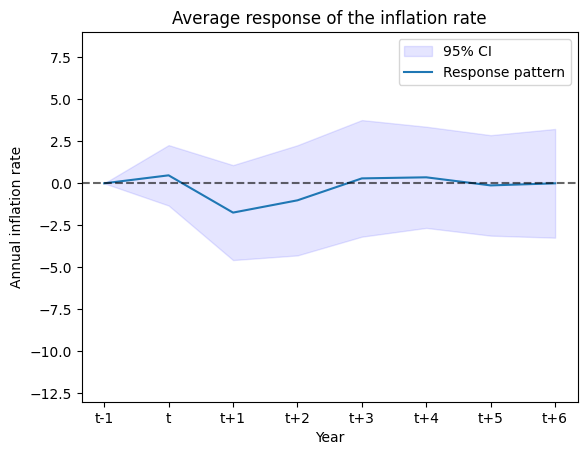

In [41]:
plt.title('Average response of the inflation rate')
plt.fill_between(
    range(len(average_pattern)),
    average_pattern - confidence_interval,
    average_pattern + confidence_interval,
    color='blue',
    alpha=0.1, label='95% CI'
)

sns.lineplot(x=years, y=average_pattern, label = 'Response pattern')
plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.6)

plt.xlabel('Year')
plt.ylabel('Annual inflation rate')

plt.ylim(-13,9)
plt.show()

### 2.3.3 Count only the beginning of the crises and treat the series as one event

A other approach to record the crisis event in the data is to <u> consider the period when crisis occur during consecutive years only as one crisis</u> , time t being the year when the first state of crisis was recorded. 

In [42]:
banking_crisis_first_year = [banking_crisis_years[0]]
for i in range (1, len(banking_crisis_years)):
    if banking_crisis_years[i]-banking_crisis_years[i-1]>=2:
        banking_crisis_first_year.append(banking_crisis_years[i])
print(f'In this aproch, we record {len(banking_crisis_first_year)} different crisis event.')

In this aproch, we record 16 different crisis event.


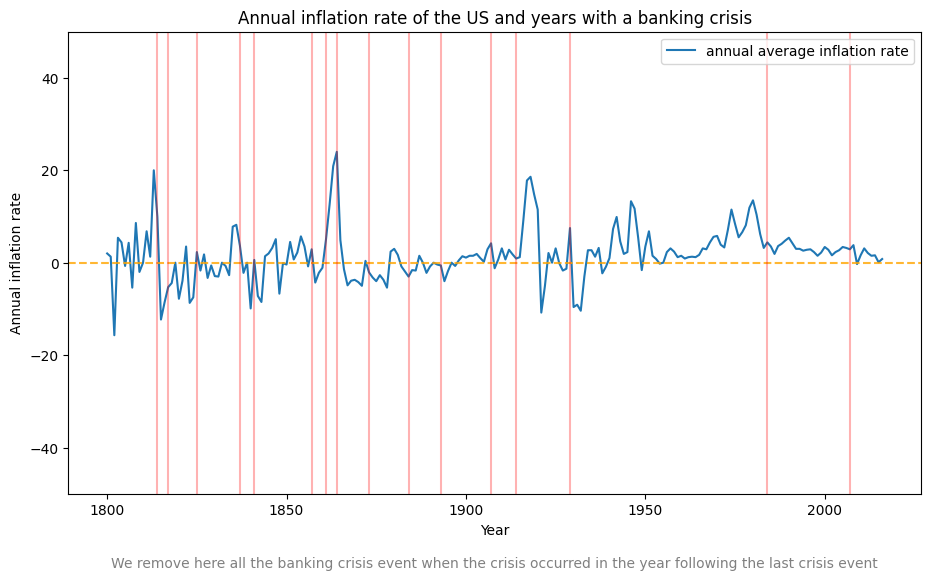

In [43]:
plt.figure(figsize=(11,6))

sns.lineplot(x=USA_data['Year'], y=USA_data['annual_inflation'], label = 'annual average inflation rate')
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

for year in banking_crisis_first_year:
    plt.axvline(x=year, color='red', linestyle='-', label='Crisis Period', alpha = 0.3)

plt.ylim(-50, 50)

plt.title('Annual inflation rate of the US and years with a banking crisis')
plt.xlabel('Year')
plt.ylabel('Annual inflation rate')

subtitle_text = "We remove here all the banking crisis event when the crisis occurred in the year following the last crisis event"
plt.annotate(subtitle_text,
             xy=(0.5, -0.15),  # Position of the text (relative to the plot)
             xycoords='axes fraction',
             ha='center', va='center',  # Centered text
             fontsize=10,
             color='gray')

plt.show()

We extract the series for the years selected, normalize them and compute the average pattern among them.

In [44]:
inflation_series = []
for year in banking_crisis_first_year:
    series_for_year = extract_inflation_series(USA_data, year)
    inflation_series.append(series_for_year)
inflation_series = np.array(inflation_series)

In [45]:
norm_inflation_series = []
for array in inflation_series:
    norm_inflation_series.append(array - array[0])
norm_inflation_series = np.array(norm_inflation_series)

In [46]:
average_pattern = np.mean(norm_inflation_series, axis=0)
confidence_interval = 1.96 * np.std(norm_inflation_series, axis=0) / np.sqrt(norm_inflation_series.shape[0])

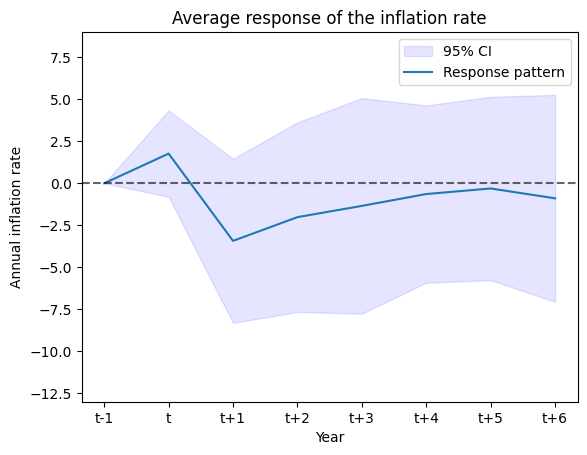

In [47]:
plt.fill_between(
    range(len(average_pattern)),
    average_pattern - confidence_interval,
    average_pattern + confidence_interval,
    color='blue',
    alpha=0.1, label='95% CI'
)

sns.lineplot(x=years, y=average_pattern, label = 'Response pattern')
plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.6)

plt.title('Average response of the inflation rate')
plt.xlabel('Year')
plt.ylabel('Annual inflation rate')

plt.ylim(-13,9)
plt.show()

### 2.3.4 Count only the beginning of the crises and treat the series as one event with adding a larger weight on a multi-year crisis

An other approach is still to consider the first year of crisis as the event of the crisis, but to also computing the average pattern of the inflation rate with the weights of the duration of the crisis. For example, a crisis that last for three years will count three time as much as a crisis that last for one year only. <br>  
We first need to extract the length of each of the crisis event recorded. 

In [48]:
crisis_duration = []
current_length = 0

for value in USA_data['banking_crisis']:
    if value == 1:
        current_length += 1
    elif current_length > 0:
        crisis_duration.append(current_length)
        current_length = 0

# Check if the last sequence extends to the end of the dataset
if current_length > 0:
    crisis_duration.append(current_length)

print(crisis_duration)

[1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 8, 4]


In [49]:
len(crisis_duration)

16

In [50]:
weighted_average_pattern = np.average(norm_inflation_series, axis=0, weights=crisis_duration)
weighted_std = np.sqrt(np.average((norm_inflation_series - weighted_average_pattern)**2, axis=0, weights=crisis_duration))
weighted_confidence_interval = 1.96 * weighted_std / np.sqrt(sum(crisis_duration))

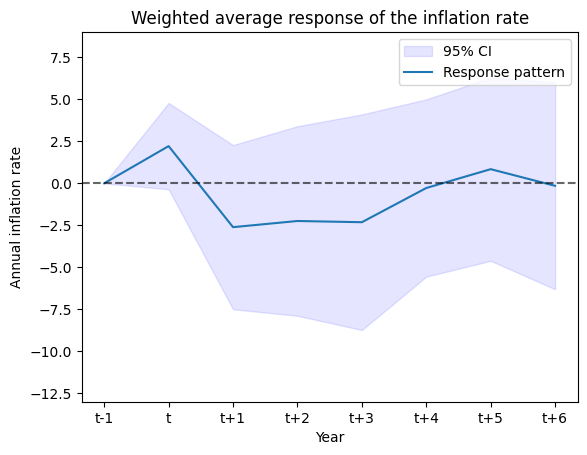

In [51]:
plt.fill_between(
    range(len(weighted_average_pattern)),
    weighted_average_pattern - confidence_interval,
    weighted_average_pattern + confidence_interval,
    color='blue',
    alpha=0.1, label='95% CI'
)

sns.lineplot(x=years, y=weighted_average_pattern, label = 'Response pattern')
plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.6)

plt.title('Weighted average response of the inflation rate')
plt.xlabel('Year')
plt.ylabel('Annual inflation rate')

plt.ylim(-13,9)
plt.show()

### 2.3.5 Estimate the response for single year and multi-year crisis separately

We are interested in noticing the difference of response when the crisis hits the economy multiple time or a single time 

#### 2.3.5.1 Single year crisis

In [52]:
#Create an empty list
single_year_norm_inflation_series = []
#Appending the series for single year crisis
for i in range (0,len(norm_inflation_series)):
    if crisis_duration[i] == 1:
        single_year_norm_inflation_series.append(norm_inflation_series[i])
#Convert the list to a Numpy array
single_year_norm_inflation_series = np.array(single_year_norm_inflation_series)
single_year_norm_inflation_series

array([[  0. , -10.1, -32.3, -28.6, -25.3, -24.4, -20. , -27.8],
       [  0. ,   9.8,   5.8,   9.3,   4.2,   6.9,   4.6,   4.5],
       [  0. ,  10.5,   2.7,   1.4,  11.3,  11.9,  13.1,  15. ],
       [  0. ,   3.7,  -3.5,  -1.4,  -0.3,   5.9,  13.4,  21.7],
       [  0. ,   6.2,  13.7,  22. ,  25.1,   6. ,  -0.3,  -3.8],
       [  0. ,   3.1, -16. , -22.3, -25.8, -24.8, -24.6, -25.1],
       [  0. ,  -2.5,  -3.6,  -4.4,  -3.1,  -4.1,  -5.8,   2. ],
       [  0. ,  -1.1,   0.3,   0.2,   3.4,   1.9,  -0.3,   1.1],
       [  0. ,  -0.2,  -3.6,  -1.4,   0.4,  -0.3,   0.9,   1.8],
       [  0. ,   1.3,  -4.1,  -2.2,   0.2,  -2.2,  -0.1,  -1.1],
       [  0. ,  -0.9,  -0.6,   7.4,  16. ,  16.8,  13. ,   9.7]])

In [53]:
single_year_average_pattern = np.mean(single_year_norm_inflation_series, axis=0)
single_year_confidence_interval = 1.96 * np.std(single_year_norm_inflation_series, axis=0) / np.sqrt(single_year_norm_inflation_series.shape[0])

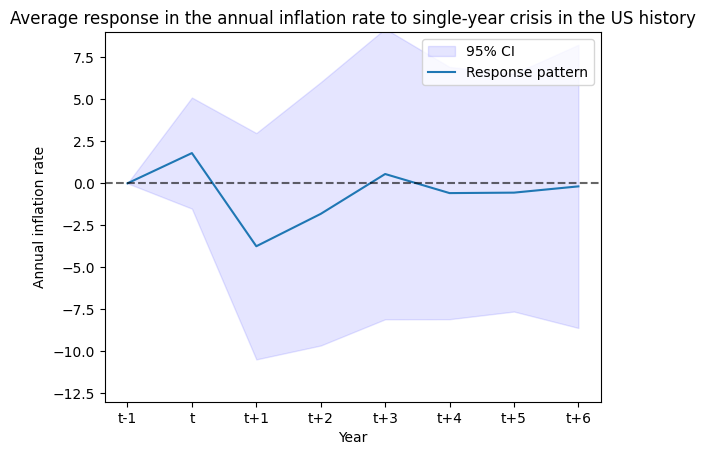

In [54]:
plt.fill_between(
    range(len(single_year_average_pattern)),
    single_year_average_pattern - single_year_confidence_interval,
    single_year_average_pattern + single_year_confidence_interval,
    color='blue',
    alpha=0.1, label='95% CI'
)

sns.lineplot(x=years, y=single_year_average_pattern, label = 'Response pattern')
plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.6)

plt.title('Average response in the annual inflation rate to single-year crisis in the US history')
plt.xlabel('Year')
plt.ylabel('Annual inflation rate')

plt.ylim(-13,9)
plt.show()

#### 2.3.5.2 Multiyear crisis

In [55]:
multi_year_crisis_duration = []
for i in range (0, len(crisis_duration)):
    if crisis_duration[i] >1:
        multi_year_crisis_duration.append(crisis_duration[i])
multi_year_crisis_duration

[3, 2, 5, 8, 4]

In [56]:
#Create an empty list
multi_year_norm_inflation_series = []
#Appending the series for single year crisis
for i in range (0,len(norm_inflation_series)):
    if crisis_duration[i] > 1:
        multi_year_norm_inflation_series.append(norm_inflation_series[i])
#Convert the list to a Numpy array
multi_year_norm_inflation_series = np.array(multi_year_norm_inflation_series)

In [57]:
multi_year_weighted_average_pattern = np.average(multi_year_norm_inflation_series, axis=0, weights=multi_year_crisis_duration)
multi_year_weighted_std = np.sqrt(np.average((multi_year_norm_inflation_series - multi_year_weighted_average_pattern)**2, axis=0, weights=multi_year_crisis_duration))
multi_year_weighted_confidence_interval = 1.96 * multi_year_weighted_std / np.sqrt(sum(multi_year_crisis_duration))

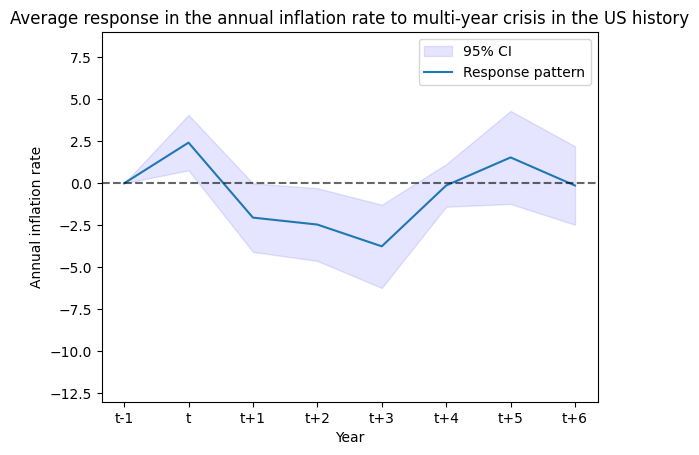

In [58]:
plt.fill_between(
    range(len(multi_year_weighted_average_pattern)),
    multi_year_weighted_average_pattern - multi_year_weighted_confidence_interval,
    multi_year_weighted_average_pattern + multi_year_weighted_confidence_interval,
    color='blue',
    alpha=0.1, label='95% CI'
)

sns.lineplot(x=years, y=multi_year_weighted_average_pattern, label = 'Response pattern')
plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.6)

plt.title('Average response in the annual inflation rate to multi-year crisis in the US history')
plt.xlabel('Year')
plt.ylabel('Annual inflation rate')

plt.ylim(-13,9)
plt.show()

# 3. Estimating the GDP response to liquidity shocks - focus on the USA

I use here the GDP data provided by the Maddison Project Database in 2020. The database covers 169 countries and the period up to 2018. 

## 3.1 Extract the US data

In [59]:
GDP_pc = pd.read_csv('../raw_data/gdp-per-capita-maddison.csv')
GDP_pc.drop(columns='417485-annotations', inplace = True)
GDP_pc.rename(columns={'GDP per capita':'GDP_per_capita'}, inplace = True)
GDP_pc.dtypes

Entity             object
Code               object
Year                int64
GDP_per_capita    float64
dtype: object

In [60]:
US_GDP_pc = GDP_pc.loc[GDP_pc['Entity']=='United States']
US_GDP_pc.head()

,Entity,Code,Year,GDP_per_capita
18834,United States,USA,1650,897.0000
18835,United States,USA,1720,1768.9856
18836,United States,USA,1775,2419.0000
18837,United States,USA,1800,2545.4880
18838,United States,USA,1801,2591.7695


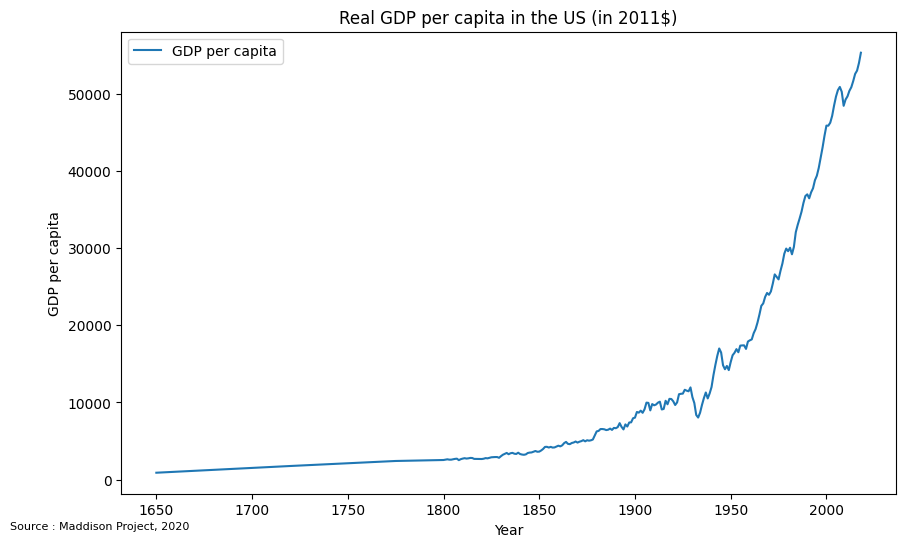

In [61]:
plt.figure(figsize=(10,6))

sns.lineplot(x=US_GDP_pc['Year'], y=US_GDP_pc['GDP_per_capita'], label = 'GDP per capita')

plt.title('Real GDP per capita in the US (in 2011$)')

plt.xlabel('Year')
plt.ylabel('GDP per capita')

plt.annotate('Source : Maddison Project, 2020', (0,0), (-80,-20), fontsize=8,
             xycoords='axes fraction', textcoords='offset points', va='top')

plt.show()

## 3.2 Compute the output gap

### 3.2.1 Detrend output

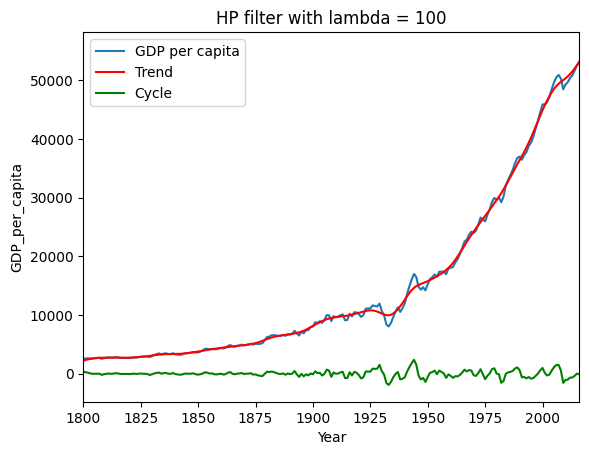

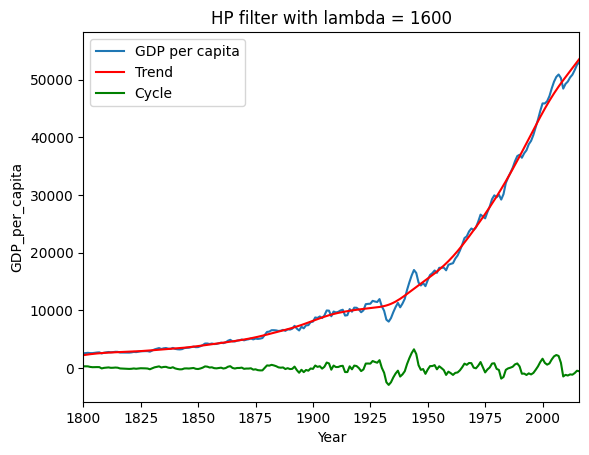

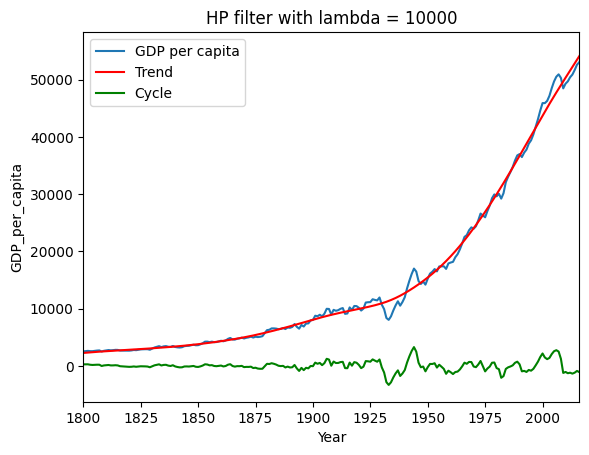

In [62]:
smoothing_param = [100, 1600, 10000]
for lam in smoothing_param:
    cycle, trend = sm.tsa.filters.hpfilter(US_GDP_pc.GDP_per_capita, lamb=lam)

    # Plot the original GDP, trend, and cycle
    sns.lineplot(x=US_GDP_pc.Year, y=US_GDP_pc.GDP_per_capita, label = 'GDP per capita')
    sns.lineplot(x=US_GDP_pc.Year, y=trend, label = 'Trend', color = 'red')
    sns.lineplot(x=US_GDP_pc.Year, y=cycle, label = 'Cycle', color = 'green')

    plt.xlim((1800, 2016))

    plt.title(f'HP filter with lambda = {lam}')
    plt.xlabel('Year')
    plt.legend()
    plt.show()


In [63]:
cycle, trend = sm.tsa.filters.hpfilter(US_GDP_pc.GDP_per_capita, lamb=1600)

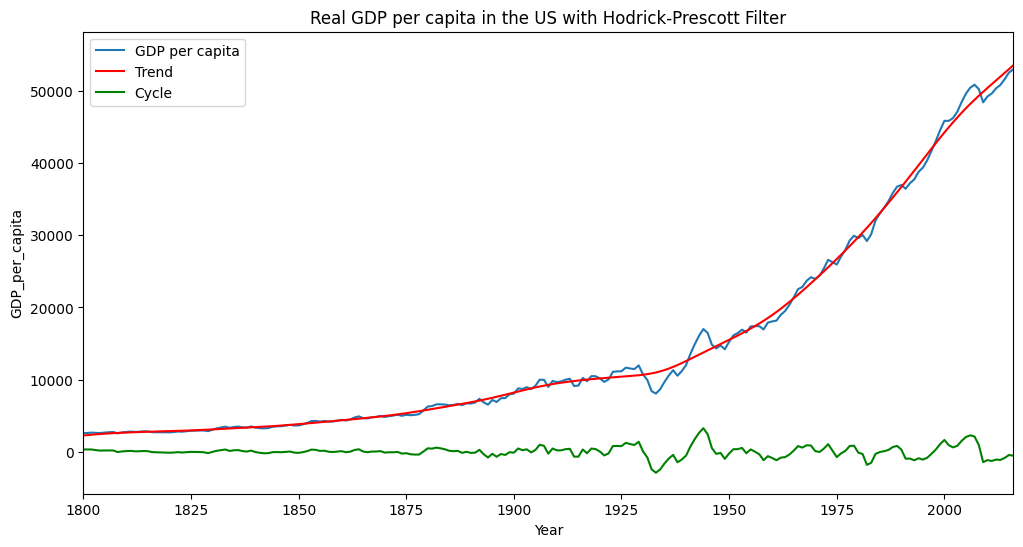

In [64]:
# Plot the original GDP, trend, and cycle
plt.figure(figsize=(12, 6))

sns.lineplot(x=US_GDP_pc.Year, y=US_GDP_pc.GDP_per_capita, label = 'GDP per capita')
sns.lineplot(x=US_GDP_pc.Year, y=trend, label = 'Trend', color = 'red')
sns.lineplot(x=US_GDP_pc.Year, y=cycle, label = 'Cycle', color = 'green')

plt.xlim((1800, 2016))

plt.title('Real GDP per capita in the US with Hodrick-Prescott Filter')
plt.xlabel('Year')
plt.legend()
plt.show()

In [65]:
trend_deviation = pd.DataFrame({
    'Year' : US_GDP_pc.Year,
    'output_gap' : ((US_GDP_pc.GDP_per_capita - trend)/trend)*100})
trend_deviation.head()

,Year,output_gap
18834,1650,-56.277846
18835,1720,-16.307250
18836,1775,11.217376
18837,1800,13.906628
18838,1801,13.080624


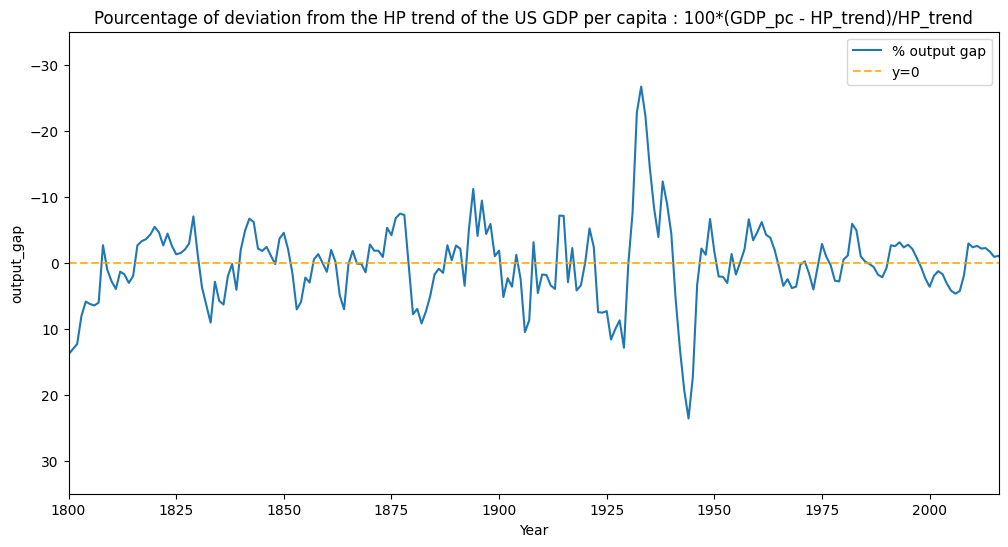

In [66]:
plt.figure(figsize=(12, 6))

sns.lineplot(x=trend_deviation.Year, y=trend_deviation['output_gap'], label = '% output gap')
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('Pourcentage of deviation from the HP trend of the US GDP per capita : 100*(GDP_pc - HP_trend)/HP_trend')
plt.xlabel('Year')
plt.xlim((1800, 2016))
plt.ylim((35,-35))

plt.legend()
plt.show()

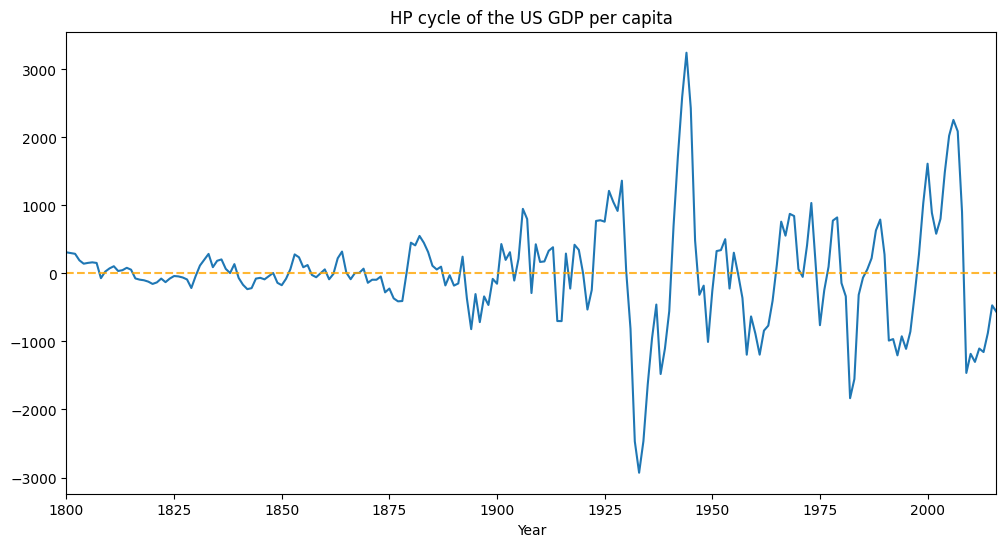

In [67]:
plt.figure(figsize=(12, 6))

sns.lineplot(x=US_GDP_pc.Year, y=cycle)
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('HP cycle of the US GDP per capita')
plt.xlabel('Year')
plt.ylabel('')

plt.xlim((1800, 2016))

plt.show()

### 3.2.2 With output gap data

I take the quaterly data of Real Potential GDP issued by FRED from 1950 to 2025. I want to convert the data to annual data fr comparison purpose with my previous work.

In [68]:
US_GDPPOT = pd.read_csv('../raw_data/USA/GDPPOT.csv')
US_GDPPOT['DATE'] = pd.to_datetime(US_GDPPOT['DATE'])
US_GDPPOT.head()

,DATE,GDPPOT
0,1950-01-01,2218.566586
1,1950-04-01,2248.161822
2,1950-07-01,2277.049682
3,1950-10-01,2306.715167
4,1951-01-01,2336.504742


In [69]:
# Resample the data to annual frequency by taking the mean of the quarters for each year
US_GDPPOT_annual = US_GDPPOT.resample('A', on='DATE').mean()
US_GDPPOT_annual.reset_index(inplace=True)
US_GDPPOT_annual['DATE'] = US_GDPPOT_annual['DATE'].dt.year

#As the data is expressed in Billions of Dollars, I multiply the TS by 10**9.
US_GDPPOT_annual['GDPPOT'] = US_GDPPOT_annual['GDPPOT']*10**9

#Filter the data from 1950 to 2018.
US_GDPPOT_annual = US_GDPPOT_annual[(US_GDPPOT_annual['DATE'] >= 1950) & (US_GDPPOT_annual['DATE'] <= 2018)]
US_GDPPOT_annual.set_index('DATE', inplace= True)

I import a database of the population in the US to compute the Real Potential GDP per capita.

In [70]:
US_pop =pd.read_csv('../raw_data/USA/Population.csv')
US_pop.DATE = pd.to_datetime(US_pop.DATE)
US_pop['DATE'] = US_pop['DATE'].dt.year

#As the data is expressed in Thousands, I multiply the TS by 10**3.
US_pop['POPULATION'] = US_pop['POPULATION']*10**3

#Filter the data from 1950 to 2018.
US_pop = US_pop[(US_pop['DATE'] >= 1950) & (US_pop['DATE'] <= 2018)]
US_pop.set_index('DATE', inplace= True)

In [71]:
US_GDPPOT_pc = pd.DataFrame({'GDPPOT_pc':US_GDPPOT_annual['GDPPOT']/US_pop['POPULATION']})
US_GDPPOT_pc.head()

,GDPPOT_pc
DATE,
1950,14916.690714
1951,15444.755071
1952,16073.021841
1953,16570.956833
1954,16744.828838


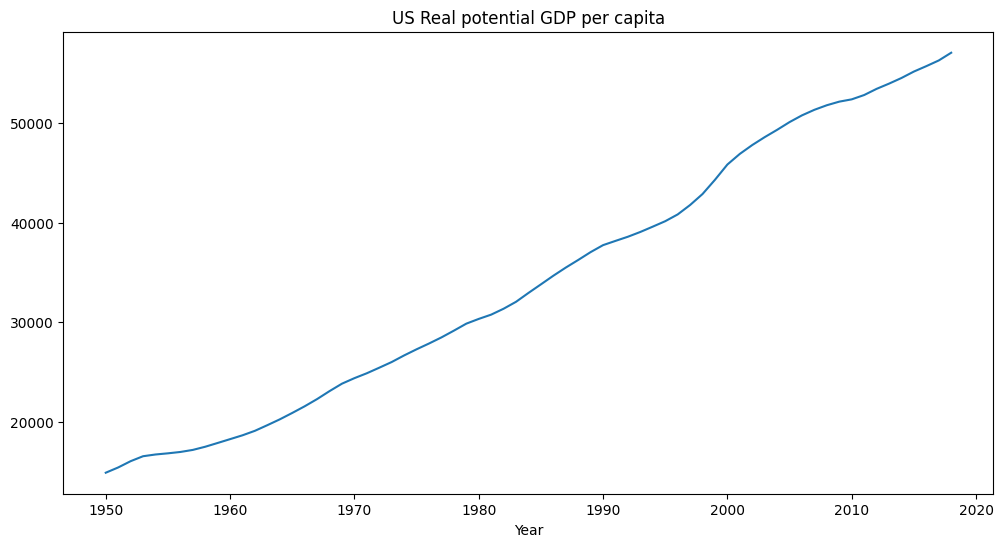

In [72]:
plt.figure(figsize=(12, 6))

sns.lineplot(x=US_GDPPOT_pc.index, y=US_GDPPOT_pc['GDPPOT_pc'])

plt.title('US Real potential GDP per capita')
plt.xlabel('Year')
plt.ylabel('')

plt.show()

We now compute the output gap by using the US_GDP_pc database. 

In [73]:
US_GDP_pc_filtered = US_GDP_pc[(US_GDP_pc['Year'] >= 1950) & (US_GDP_pc['Year'] <= 2018)]
US_GDP_pc_filtered.set_index(US_GDPPOT_pc.index, inplace=True)

#Compute the pourcentage of deviation of the output gap
Percent_output_gap = 100*(US_GDP_pc_filtered['GDP_per_capita'] - US_GDPPOT_pc['GDPPOT_pc'])/US_GDPPOT_pc['GDPPOT_pc']

Percent_output_gap = pd.DataFrame({'%_Output_gap_pc': Percent_output_gap})
Percent_output_gap.head()

,%_Output_gap_pc
DATE,
1950,2.167433
1951,4.404375
1952,2.308080
1953,2.088251
1954,-1.390452


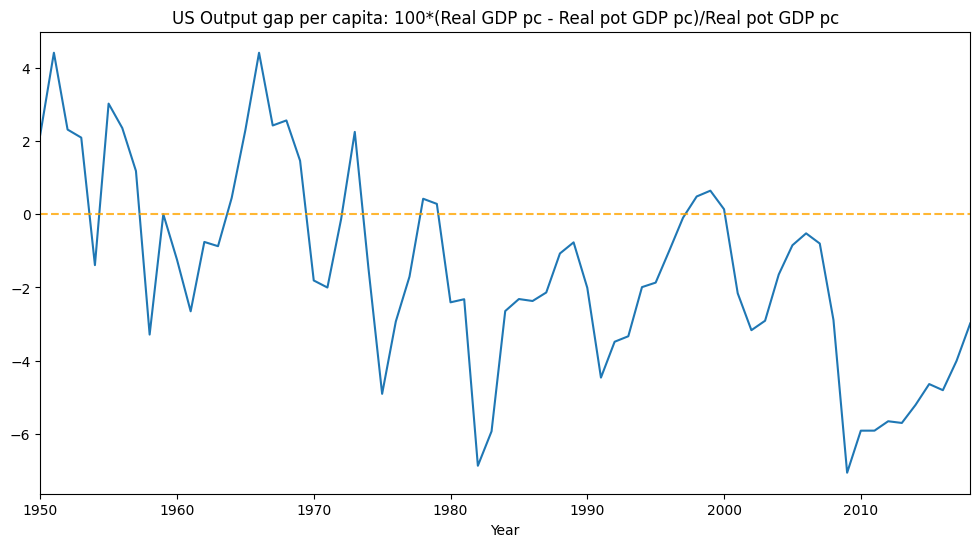

In [74]:
plt.figure(figsize=(12, 6))

sns.lineplot(x=Percent_output_gap.index, y=Percent_output_gap['%_Output_gap_pc'])

plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('US Output gap per capita: 100*(Real GDP pc - Real pot GDP pc)/Real pot GDP pc')
plt.xlabel('Year')
plt.ylabel('')

plt.xlim(1950,2018)

plt.show()

## 3.3 Compute the shock response in the output gap

### 3.3.1 Define functions to plot the data

I first define a function to extract the data from the dataset. 

In [75]:
def extract_output_gap_series(data, target_year):
    target_index = data[data['Year'] == target_year].index[0]
    series = data.loc[target_index-1:target_index+6, 'output_gap']
    return np.array(series)

### 3.3.2 Treat each year of crises as an individual event

I first extract the series for each event of banking crisis in the dataset. 

In [76]:
output_gap_series_all = []
for year in banking_crisis_years:
    output_gap_series_all.append(extract_output_gap_series(trend_deviation, year))
output_gap_series_all = np.array(output_gap_series_all)

I then normalize the serie to the first data of the serie at time t-1. 

In [77]:
norm_output_gap_series_all = []
for array in output_gap_series_all:
    norm_output_gap_series_all.append(array - array[0])
norm_output_gap_series_all = np.array(norm_output_gap_series_all)

I compute the average pattern by taking the mean of the normalized series, and the confidence interval of the pattern defned as 1.96*(standard deviation) divided by the squared root of the number of series.

In [78]:
average_pattern_output_gap_all = np.mean(output_gap_series_all, axis=0)
confidence_interval_output_gap_all = 1.96 * np.std(output_gap_series_all, axis=0) / np.sqrt(output_gap_series_all.shape[0])

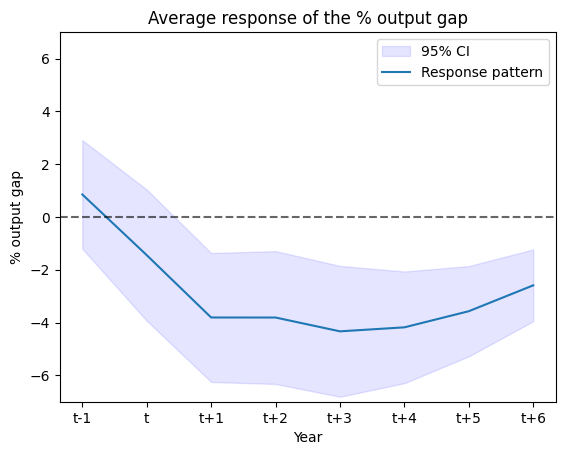

In [79]:
plt.title('Average response of the % output gap')
plt.fill_between(
    range(len(average_pattern_output_gap_all)),
    average_pattern_output_gap_all - confidence_interval_output_gap_all,
    average_pattern_output_gap_all + confidence_interval_output_gap_all,
    color='blue',
    alpha=0.1, label='95% CI'
)

sns.lineplot(x=years, y=average_pattern_output_gap_all, label = 'Response pattern')
plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.6)

plt.xlabel('Year')
plt.ylabel('% output gap')

plt.ylim(-7,7)
plt.show()

### 3.3.3 Count only the beginning of the crises and treat the series as one event

I plot the output gap series with the banking crisis year.

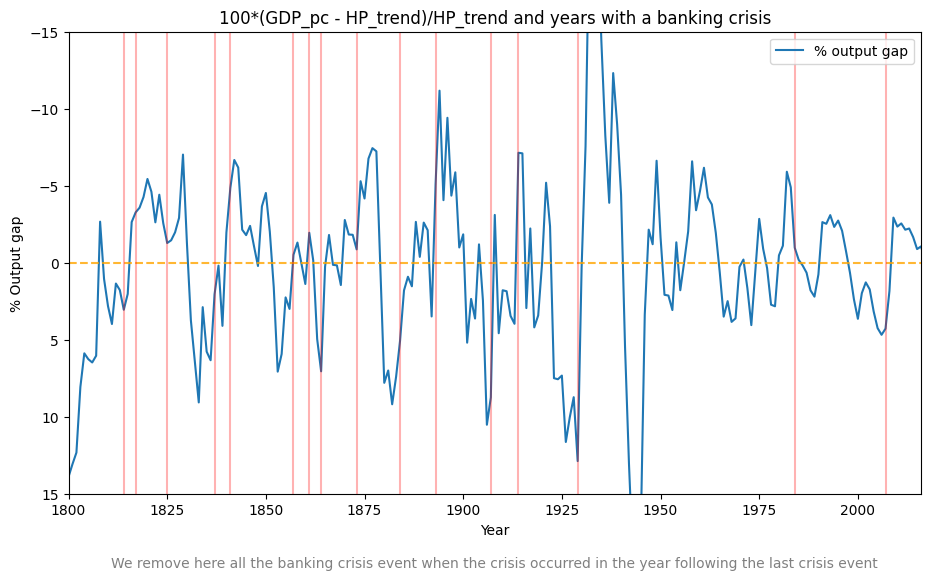

In [80]:
plt.figure(figsize=(11,6))

sns.lineplot(x=trend_deviation.Year, y=trend_deviation['output_gap'], label = '% output gap')
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

for year in banking_crisis_first_year:
    plt.axvline(x=year, color='red', linestyle='-', label='Crisis Period', alpha = 0.3)

plt.xlim((1800, 2016))
plt.ylim((15,-15))

plt.title('100*(GDP_pc - HP_trend)/HP_trend and years with a banking crisis')
plt.xlabel('Year')
plt.ylabel('% Output gap')

subtitle_text = "We remove here all the banking crisis event when the crisis occurred in the year following the last crisis event"
plt.annotate(subtitle_text,
             xy=(0.5, -0.15),  # Position of the text (relative to the plot)
             xycoords='axes fraction',
             ha='center', va='center',  # Centered text
             fontsize=10,
             color='gray')

plt.show()

I extract a serie of the output gap for each banking crisis year, normalize them to time t-1 and compute the averagere response. 

In [81]:
output_gap_series = []
for year in banking_crisis_first_year:
    output_series_for_year = extract_output_gap_series(trend_deviation, year)
    output_gap_series.append(output_series_for_year)
output_gap_series = np.array(output_gap_series)

In [82]:
norm_output_gap_series = []
for array in output_gap_series:
    norm_output_gap_series.append(array - array[0])
norm_output_gap_series = np.array(norm_output_gap_series)

In [83]:
average_pattern_output_gap = np.mean(output_gap_series, axis=0)
confidence_interval_output_gap = 1.96 * np.std(output_gap_series, axis=0) / np.sqrt(output_gap_series.shape[0])

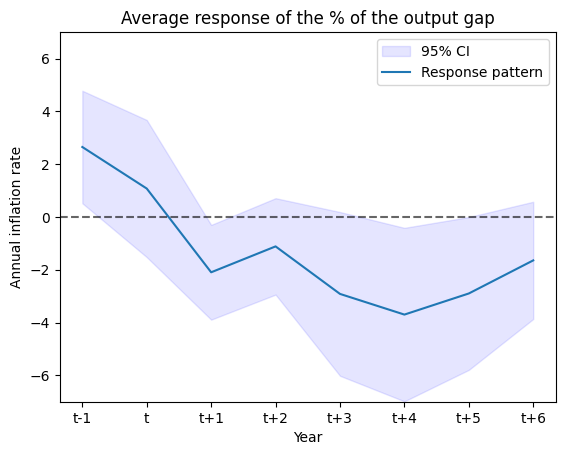

In [84]:
plt.fill_between(
    range(len(average_pattern_output_gap)),
    average_pattern_output_gap - confidence_interval_output_gap,
    average_pattern_output_gap + confidence_interval_output_gap,
    color='blue',
    alpha=0.1, label='95% CI'
)

sns.lineplot(x=years, y=average_pattern_output_gap, label = 'Response pattern')
plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.6)

plt.title('Average response of the % of the output gap')
plt.xlabel('Year')
plt.ylabel('Annual inflation rate')

plt.ylim(-7,7)
plt.show()

### 3.4.4 Count only the beginning of the crisis and the treat the series as one event with weights of the duration of the crisis

In [85]:
weighted_average_pattern_output_gap = np.average(output_gap_series, axis=0, weights=crisis_duration)
weighted_std_output_gap = np.sqrt(np.average((output_gap_series - weighted_average_pattern_output_gap)**2, axis=0, weights=crisis_duration))
weighted_confidence_interval_output_gap = 1.96 * weighted_std_output_gap / np.sqrt(sum(crisis_duration))

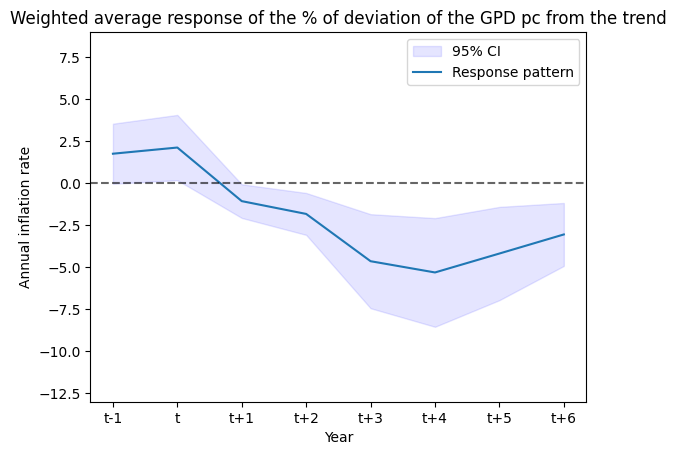

In [86]:
plt.fill_between(
    range(len(weighted_average_pattern_output_gap)),
    weighted_average_pattern_output_gap - weighted_confidence_interval_output_gap,
    weighted_average_pattern_output_gap + weighted_confidence_interval_output_gap,
    color='blue',
    alpha=0.1, label='95% CI'
)

sns.lineplot(x=years, y=weighted_average_pattern_output_gap, label = 'Response pattern')
plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.6)

plt.title('Weighted average response of the % of deviation of the GPD pc from the trend')
plt.xlabel('Year')
plt.ylabel('Annual inflation rate')

plt.ylim(-13,9)
plt.show()

### 3.4.5 Estimate the response for single-year and multi-year crisis

#### 3.4.5.1 Single-year crisis

In [87]:
#Create an empty list
single_year_output_gap_series = []
#Appending the series for single year crisis
for i in range (0,len(output_gap_series)):
    if crisis_duration[i] == 1:
        single_year_output_gap_series.append(output_gap_series[i])
#Convert the list to a Numpy array
single_year_output_gap_series = np.array(single_year_output_gap_series)

In [88]:
single_year_average_pattern_output_gap = np.mean(single_year_output_gap_series, axis=0)
single_year_confidence_interval_output_gap = 1.96 * np.std(single_year_output_gap_series, axis=0) / np.sqrt(single_year_output_gap_series.shape[0])

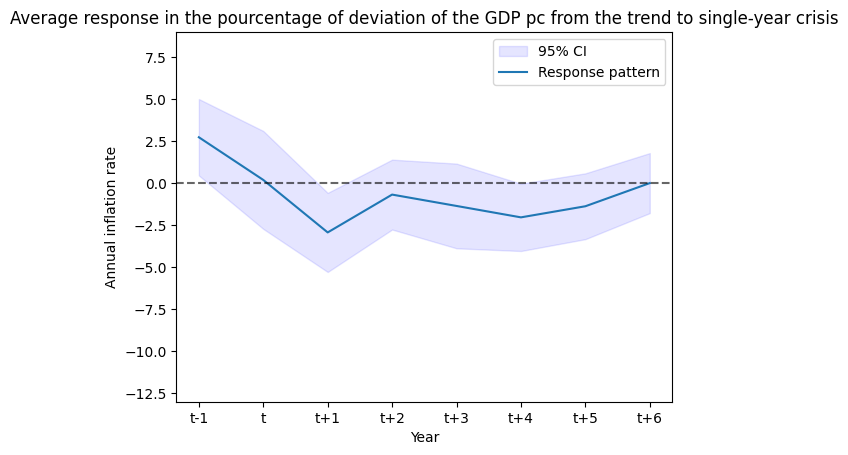

In [89]:
plt.fill_between(
    range(len(single_year_average_pattern_output_gap)),
    single_year_average_pattern_output_gap - single_year_confidence_interval_output_gap,
    single_year_average_pattern_output_gap + single_year_confidence_interval_output_gap,
    color='blue',
    alpha=0.1, label='95% CI'
)

sns.lineplot(x=years, y=single_year_average_pattern_output_gap, label = 'Response pattern')
plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.6)

plt.title('Average response in the pourcentage of deviation of the GDP pc from the trend to single-year crisis')
plt.xlabel('Year')
plt.ylabel('Annual inflation rate')

plt.ylim(-13,9)
plt.show()

#### 3.4.5.2 Multi-year crisis

In [90]:
#Create an empty list
multi_year_output_gap_series = []
#Appending the series for single year crisis
for i in range (0,len(output_gap_series)):
    if crisis_duration[i] > 1:
        multi_year_output_gap_series.append(output_gap_series[i])
#Convert the list to a Numpy array
multi_year_output_gap_series = np.array(multi_year_output_gap_series)

In [91]:
multi_year_weighted_average_pattern_output_gap = np.average(multi_year_output_gap_series, axis=0, weights=multi_year_crisis_duration)
multi_year_weighted_std_output_gap = np.sqrt(np.average((multi_year_output_gap_series - multi_year_weighted_average_pattern_output_gap)**2, axis=0, weights=multi_year_crisis_duration))
multi_year_weighted_confidence_interval_output_gap = 1.96 * multi_year_weighted_std_output_gap / np.sqrt(sum(multi_year_crisis_duration))

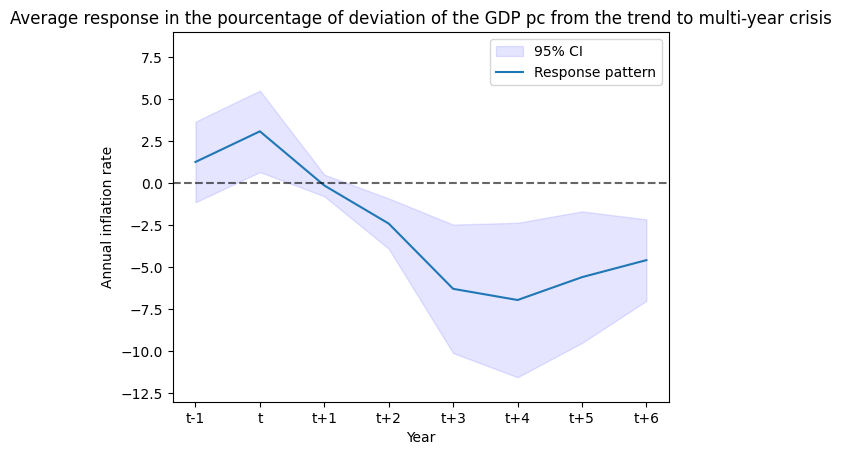

In [92]:
plt.fill_between(
    range(len(multi_year_weighted_average_pattern_output_gap)),
    multi_year_weighted_average_pattern_output_gap - multi_year_weighted_confidence_interval_output_gap,
    multi_year_weighted_average_pattern_output_gap + multi_year_weighted_confidence_interval_output_gap,
    color='blue',
    alpha=0.1, label='95% CI'
)

sns.lineplot(x=years, y=multi_year_weighted_average_pattern_output_gap, label = 'Response pattern')
plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.6)

plt.title('Average response in the pourcentage of deviation of the GDP pc from the trend to multi-year crisis')
plt.xlabel('Year')
plt.ylabel('Annual inflation rate')

plt.ylim(-13,9)
plt.show()

# 4. Focus on the negative demand shocks

## 4.1 Focus on each crisis recorded

In [93]:
crisis_dict_inflation = {}
for key, value in zip(banking_crisis_first_year,inflation_series):
    crisis_dict_inflation[f"Crisis of {key}"]=value

In [94]:
crisis_dict_inflation.keys()

dict_keys(['Crisis of 1814', 'Crisis of 1817', 'Crisis of 1825', 'Crisis of 1837', 'Crisis of 1841', 'Crisis of 1857', 'Crisis of 1861', 'Crisis of 1864', 'Crisis of 1873', 'Crisis of 1884', 'Crisis of 1893', 'Crisis of 1907', 'Crisis of 1914', 'Crisis of 1929', 'Crisis of 1984', 'Crisis of 2007'])

In [95]:
crisis_dict_output_gap = {}
for key, value in zip(banking_crisis_first_year,output_gap_series):
    crisis_dict_output_gap[f"Crisis of {key}"]=value

In [96]:
# crisis_dict_GDP_pc = {}
# for key, value in zip(banking_crisis_first_year,output_series):
#     crisis_dict_GDP_pc[f"Crisis of {key}"]=value

NameError: name 'output_series' is not defined

## 4.2 Inflation rate : examine the difference in the response in each of the crisis

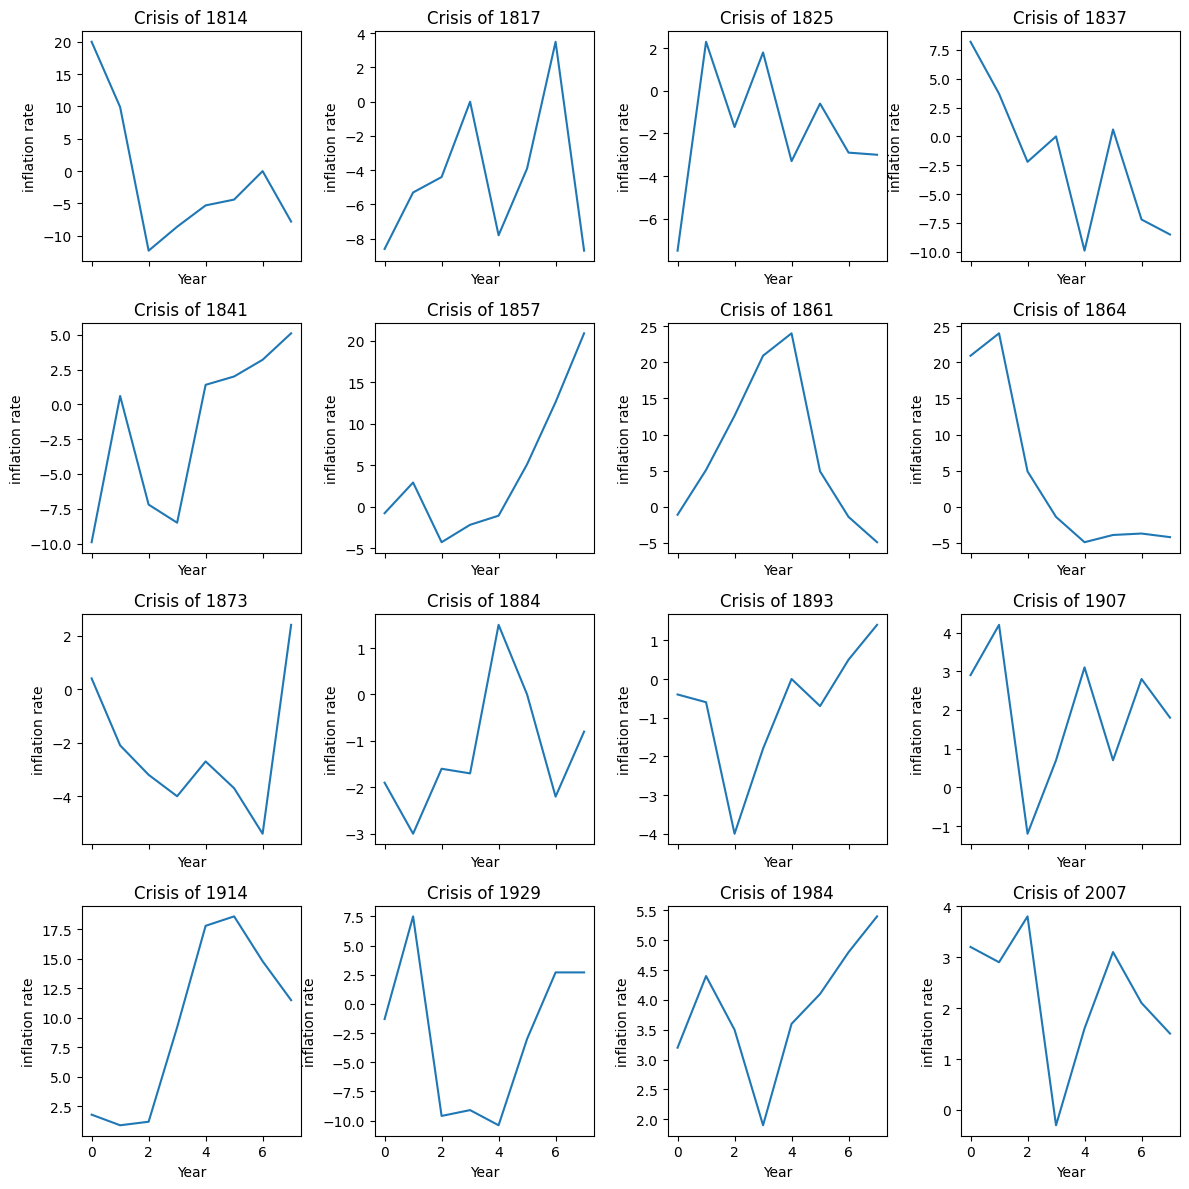

In [97]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), sharex=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each series in a separate subplot
for i, (series_name, series_data) in enumerate(crisis_dict_inflation.items()):
    row = i // 4
    col = i % 4
    axes[i].plot(series_data, label=series_name)
    axes[i].set_title(series_name)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('inflation rate')
    # axes[i].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

## 4.3 Output gap : examine the difference in the response in each of the crisis

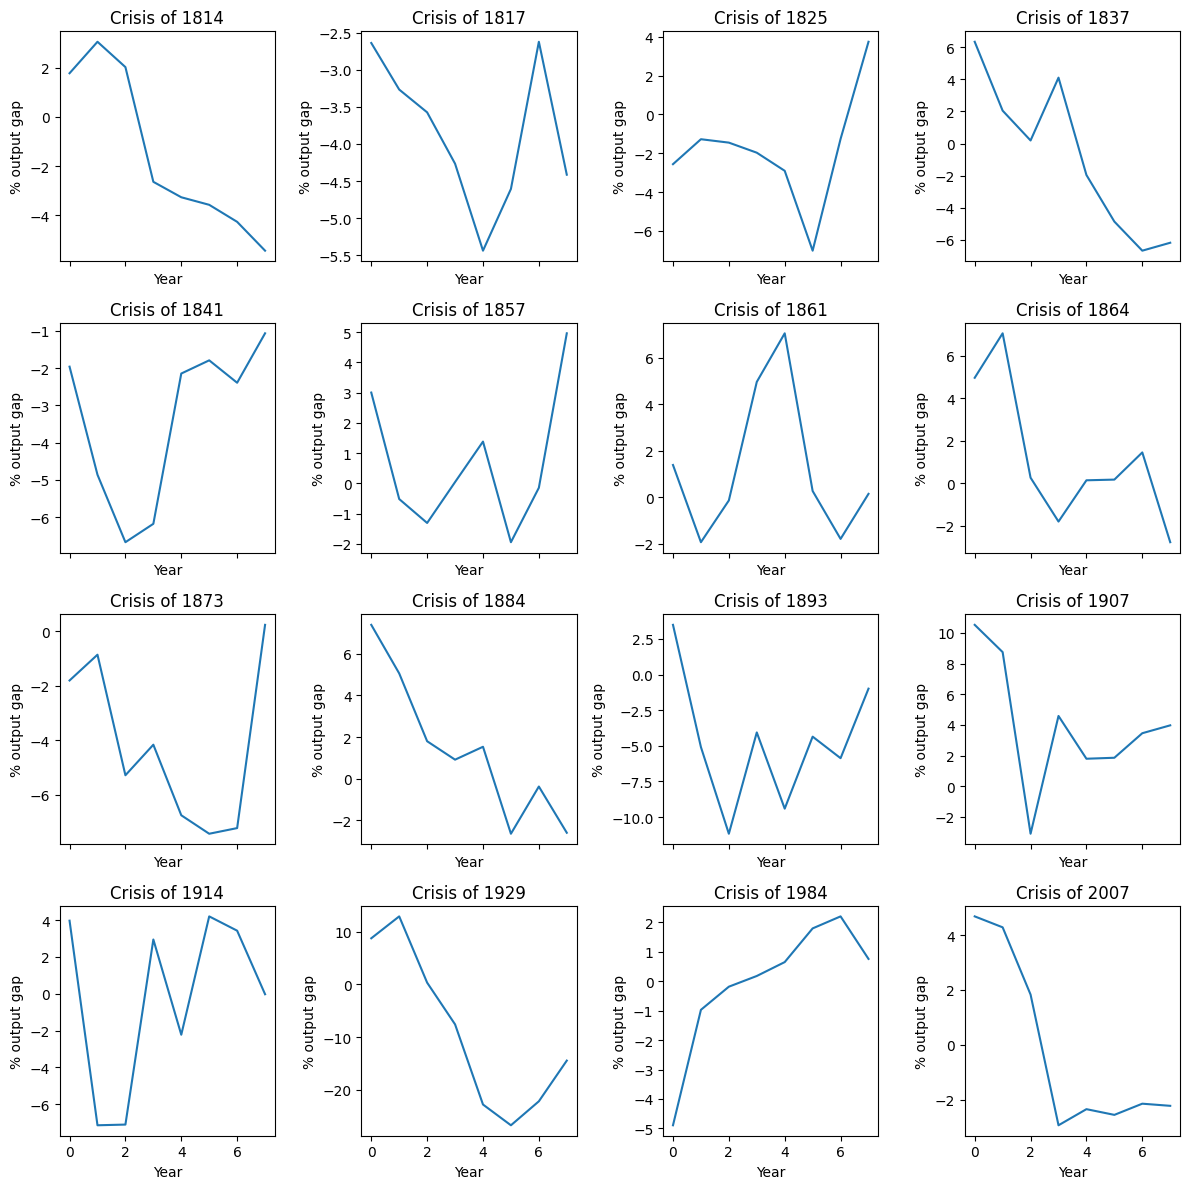

In [98]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), sharex=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each series in a separate subplot
for i, (series_name, series_data) in enumerate(crisis_dict_output_gap.items()):
    row = i // 4
    col = i % 4
    axes[i].plot(series_data, label=series_name)
    axes[i].set_title(series_name)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('% output gap')
    # axes[i].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

## 4.4 GDP per capita : examine the difference in the response in each of the crisis

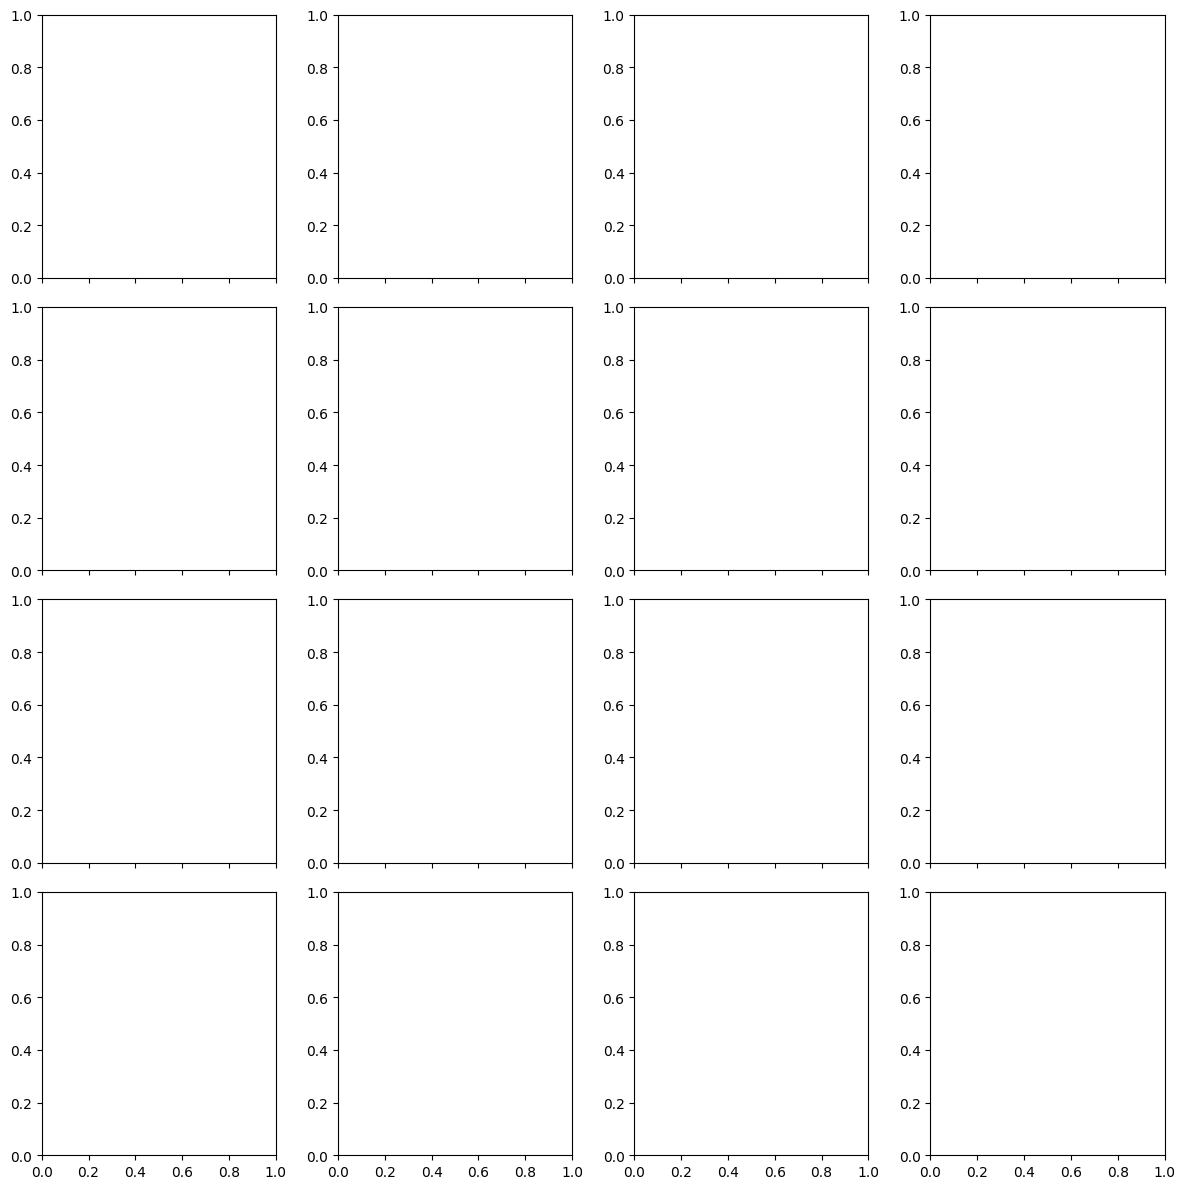

In [99]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), sharex=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each series in a separate subplot
for i, (series_name, series_data) in enumerate(crisis_dict_GDP_pc.items()):
    row = i // 4
    col = i % 4
    axes[i].plot(series_data, label=series_name)
    axes[i].set_title(series_name)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('GDP per capita')
    # axes[i].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# 5. How does the length of the period without a banking crisis affect the severity of the next crisis? 

## 5.1 Analysis with US data

Our dependant variable will be the normalized inflation rate at time t+1.

In [100]:
y_US = norm_inflation_series[1:,2]
y_US

array([  4.2,   5.8, -10.4,   2.7,  -3.5,  13.7, -16. ,  -3.6,   0.3,
        -3.6,  -4.1,  -0.6,  -8.3,   0.3,   0.6])

We are taking as explicative variable the difference between the fist year of a crisis and the first year of the crisis that preceded it. 

In [101]:
US_no_crisis_period = [banking_crisis_first_year[i+1] -banking_crisis_first_year[i] for i in range(0,len(banking_crisis_first_year)-1)]
US_no_crisis_period

[3, 8, 12, 4, 16, 4, 3, 9, 11, 9, 14, 7, 15, 55, 23]

Let's create a dummy variable taking 1 if the crisis last for multiple years.

In [102]:
US_dummy_multi_crisis = [1 if crisis_duration[i]>1 else 0 for i in range(1,len(crisis_duration))]
US_dummy_multi_crisis

[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

In [103]:
X = pd.DataFrame({
                'no_crisis_period': US_no_crisis_period,
                'multi_crisis': US_dummy_multi_crisis
})

In [104]:
model = sm.OLS(y_US,sm.add_constant(X)).fit()

In [105]:
model.summary()

/home/benleng/.pyenv/versions/3.10.6/envs/ISER/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.146
Method:                 Least Squares   F-statistic:                    0.1085
Date:                Thu, 01 Feb 2024   Prob (F-statistic):              0.898
Time:                        13:49:55   Log-Likelihood:                -49.988
No. Observations:                  15   AIC:                             106.0
Df Residuals:                      12   BIC:                             108.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.1206      2.844     -0.394      0.701      -7.318       5.077
no_crisis_period     0.0271      0.180      0.150      0.883      -0.366       0.420
multi_crisis        -2.1855      4.775     -0.458      0.655     -12.590       8.219
==============================================================================
Omnibus:                        1.140   Durbin-Watson:                   2.668
Prob(Omnibus):                  0.566   Jarque-Bera (JB):                0.084
Skew:                          -0.005   Prob(JB):                        0.959
Kurtosis:                       3.366   Cond. No.                         44.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 5.2 Enriching the analysis with other countries data

### 5.2.1 Creating the independant variable dataframe

* For the United kingdom

In [106]:
UK_banking_crisis_years = UK_data[UK_data['banking_crisis'] == 1]['Year'].tolist()
print(f'''{len(UK_banking_crisis_years)} banking crisis are recorded in the United Kingdom's history.''')

33 banking crisis are recorded in the United Kingdom's history.


In [107]:
UK_banking_crisis_first_year = [UK_banking_crisis_years[0]]
for i in range (1, len(UK_banking_crisis_years)):
    if UK_banking_crisis_years[i]-UK_banking_crisis_years[i-1]>=2:
        UK_banking_crisis_first_year.append(UK_banking_crisis_years[i])
print(f'In this aproch, we record {len(UK_banking_crisis_first_year)} different crisis event.')

In this aproch, we record 15 different crisis event.


In [108]:
UK_crisis_duration = []
current_length = 0

for value in UK_data['banking_crisis']:
    if value == 1:
        current_length += 1
    elif current_length > 0:
        UK_crisis_duration.append(current_length)
        current_length = 0

# Check if the last sequence extends to the end of the dataset
if current_length > 0:
    UK_crisis_duration.append(current_length)

print(UK_crisis_duration)

[1, 4, 2, 3, 2, 2, 1, 2, 1, 1, 3, 1, 1, 1, 8]


In [109]:
UK_no_crisis_period = [UK_banking_crisis_first_year[i+1] -UK_banking_crisis_first_year[i] for i in range(0,len(UK_banking_crisis_first_year)-1)]
UK_no_crisis_period

[3, 11, 12, 10, 10, 9, 12, 12, 18, 66, 10, 7, 4, 12]

In [110]:
UK_dummy_multi_crisis = [1 if UK_crisis_duration[i]>1 else 0 for i in range(1,len(UK_crisis_duration))]
UK_dummy_multi_crisis

[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]

* For France

In [111]:
FRA_banking_crisis_years = FRA_data[FRA_data['banking_crisis'] == 1]['Year'].tolist()
print(f'''{len(FRA_banking_crisis_years)} banking crisis are recorded in France's history.''')

26 banking crisis are recorded in France's history.


In [112]:
FRA_banking_crisis_first_year = [FRA_banking_crisis_years[0]]
for i in range (1, len(FRA_banking_crisis_years)):
    if FRA_banking_crisis_years[i]-FRA_banking_crisis_years[i-1]>=2:
        FRA_banking_crisis_first_year.append(FRA_banking_crisis_years[i])
print(f'In this aproch, we record {len(FRA_banking_crisis_first_year)} different crisis event.')

In this aproch, we record 12 different crisis event.


In [113]:
FRA_crisis_duration = []
current_length = 0

for value in FRA_data['banking_crisis']:
    if value == 1:
        current_length += 1
    elif current_length > 0:
        FRA_crisis_duration.append(current_length)
        current_length = 0

# Check if the last sequence extends to the end of the dataset
if current_length > 0:
    FRA_crisis_duration.append(current_length)

print(FRA_crisis_duration)

[1, 2, 2, 2, 1, 2, 2, 1, 1, 3, 2, 7]


In [114]:
FRA_no_crisis_period = [FRA_banking_crisis_first_year[i+1] -FRA_banking_crisis_first_year[i] for i in range(0,len(FRA_banking_crisis_first_year)-1)]
FRA_no_crisis_period

[3, 22, 11, 10, 19, 14, 8, 18, 23, 64, 14]

In [115]:
FRA_dummy_multi_crisis = [1 if UK_crisis_duration[i]>1 else 0 for i in range(1,len(FRA_crisis_duration))]
FRA_dummy_multi_crisis

[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0]

* For Japan

In [116]:
JPN_banking_crisis_years = JPN_data[JPN_data['banking_crisis'] == 1]['Year'].tolist()
print(f'''{len(JPN_banking_crisis_years)} banking crisis are recorded in Japan's history.''')

24 banking crisis are recorded in Japan's history.


In [117]:
JPN_banking_crisis_first_year = [JPN_banking_crisis_years[0]]
for i in range (1, len(JPN_banking_crisis_years)):
    if JPN_banking_crisis_years[i]-JPN_banking_crisis_years[i-1]>=2:
        JPN_banking_crisis_first_year.append(JPN_banking_crisis_years[i])
print(f'In this aproch, we record {len(JPN_banking_crisis_first_year)} different crisis event.')

In this aproch, we record 8 different crisis event.


In [118]:
JPN_crisis_duration = []
current_length = 0

for value in JPN_data['banking_crisis']:
    if value == 1:
        current_length += 1
    elif current_length > 0:
        JPN_crisis_duration.append(current_length)
        current_length = 0

# Check if the last sequence extends to the end of the dataset
if current_length > 0:
    JPN_crisis_duration.append(current_length)

print(JPN_crisis_duration)

[5, 4, 1, 1, 1, 1, 1, 10]


In [119]:
JPN_no_crisis_period = [JPN_banking_crisis_first_year[i+1] -JPN_banking_crisis_first_year[i] for i in range(0,len(JPN_banking_crisis_first_year)-1)]
JPN_no_crisis_period

[10, 19, 6, 10, 6, 4, 65]

In [120]:
JPN_dummy_multi_crisis = [1 if UK_crisis_duration[i]>1 else 0 for i in range(1,len(JPN_crisis_duration))]
JPN_dummy_multi_crisis

[1, 1, 1, 1, 1, 0, 1]

* Compiling the data of all the countries

In [121]:
all_no_crisis_period = np.concatenate([US_no_crisis_period,UK_no_crisis_period,FRA_no_crisis_period,JPN_no_crisis_period])

In [122]:
all_dummy_multi_crisis = np.concatenate([US_dummy_multi_crisis,UK_dummy_multi_crisis,FRA_dummy_multi_crisis,JPN_dummy_multi_crisis])

In [123]:
X_all = pd.DataFrame({
                'no_crisis_period': all_no_crisis_period,
                'multi_crisis': all_dummy_multi_crisis
})
X_all

,no_crisis_period,multi_crisis
0,3,1
1,8,0
2,12,1
3,4,0
4,16,0
5,4,0
6,3,0
7,9,0
8,11,0
9,9,0


### 5.2.2 Creating the dependant variable dataframe

* For the United kingdom

In [124]:
UK_inflation_series = []
for year in UK_banking_crisis_first_year:
    series_for_year = extract_inflation_series(UK_data, year)
    UK_inflation_series.append(series_for_year)
UK_inflation_series = np.array(UK_inflation_series)

In [125]:
UK_norm_inflation_series = []
for array in UK_inflation_series:
    UK_norm_inflation_series.append(array - array[0])
UK_norm_inflation_series = np.array(UK_norm_inflation_series)

In [126]:
y_UK = UK_norm_inflation_series[1:,2]
y_UK

array([-13.1, -14.2, -10.2, -17.1,  -9. ,   5.2,  -3.2,   0. ,   0. ,
        15.1,   1.5,  -5.8,   0. ,   0.8])

* For France

In [127]:
FRA_inflation_series = []
for year in FRA_banking_crisis_first_year:
    series_for_year = extract_inflation_series(FRA_data, year)
    FRA_inflation_series.append(series_for_year)
FRA_inflation_series = np.array(FRA_inflation_series)

In [128]:
FRA_norm_inflation_series = []
for array in FRA_inflation_series:
    FRA_norm_inflation_series.append(array - array[0])
FRA_norm_inflation_series = np.array(FRA_norm_inflation_series)

In [129]:
y_FRA = FRA_norm_inflation_series[1:,2]
y_FRA

array([ 15.9,   5.3,   3. ,  -5.1,  -1.6,  -3.4,  -3.2,  -3.3, -10.1,
        -0.4,  -1.5])

* For Japan

In [130]:
JPN_inflation_series = []
for year in JPN_banking_crisis_first_year:
    series_for_year = extract_inflation_series(JPN_data, year)
    JPN_inflation_series.append(series_for_year)
JPN_inflation_series = np.array(JPN_inflation_series)

In [131]:
JPN_norm_inflation_series = []
for array in JPN_inflation_series:
    JPN_norm_inflation_series.append(array - array[0])
JPN_norm_inflation_series = np.array(JPN_norm_inflation_series)

In [132]:
y_JPN = JPN_norm_inflation_series[1:,2]
y_JPN

array([-25.8, -15.5,  -8.9,  22.8,   3.5,   8.3,  -2. ])

* Compiling the data of all the countries

In [133]:
y_all = np.concatenate([y_US,y_UK, y_FRA, y_JPN])
y_all

array([  4.2,   5.8, -10.4,   2.7,  -3.5,  13.7, -16. ,  -3.6,   0.3,
        -3.6,  -4.1,  -0.6,  -8.3,   0.3,   0.6, -13.1, -14.2, -10.2,
       -17.1,  -9. ,   5.2,  -3.2,   0. ,   0. ,  15.1,   1.5,  -5.8,
         0. ,   0.8,  15.9,   5.3,   3. ,  -5.1,  -1.6,  -3.4,  -3.2,
        -3.3, -10.1,  -0.4,  -1.5, -25.8, -15.5,  -8.9,  22.8,   3.5,
         8.3,  -2. ])

### 5.2.3 Fitting the Linear Regression model

In [134]:
model_all = sm.OLS(y_all,sm.add_constant(X_all)).fit()

In [135]:
model_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.8922
Date:                Thu, 01 Feb 2024   Prob (F-statistic):              0.417
Time:                        13:49:57   Log-Likelihood:                -168.63
No. Observations:                  47   AIC:                             343.3
Df Residuals:                      44   BIC:                             348.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.8589      2.180     -0.853      0.398      -6.253       2.535
no_crisis_period     0.0965      0.089      1.080      0.286      -0.084       0.277
multi_crisis        -2.9280      2.765     -1.059      0.295      -8.501       2.645
==============================================================================
Omnibus:                        5.332   Durbin-Watson:                   1.508
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                4.609
Skew:                           0.470   Prob(JB):                       0.0998
Kurtosis:                       4.212   Cond. No.                         51.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 6. Response pattern with the data 4 countries

## 6.1 In the inflation rate

* singleyear crisis

In [136]:
#UK
single_year_norm_inflation_series_UK = []
#Appending the series for single year crisis
for i in range (0,len(UK_norm_inflation_series)):
    if UK_crisis_duration[i] == 1:
        single_year_norm_inflation_series_UK.append(UK_norm_inflation_series[i])
#Convert the list to a Numpy array
single_year_norm_inflation_series_UK = np.array(single_year_norm_inflation_series_UK)

#France
single_year_norm_inflation_series_FRA = []
#Appending the series for single year crisis
for i in range (0,len(FRA_norm_inflation_series)):
    if FRA_crisis_duration[i] == 1:
        single_year_norm_inflation_series_FRA.append(FRA_norm_inflation_series[i])
#Convert the list to a Numpy array
single_year_norm_inflation_series_FRA = np.array(single_year_norm_inflation_series_FRA)

#Japan
single_year_norm_inflation_series_JPN = []
#Appending the series for single year crisis
for i in range (0,len(JPN_norm_inflation_series)):
    if JPN_crisis_duration[i] == 1:
        single_year_norm_inflation_series_JPN.append(JPN_norm_inflation_series[i])
#Convert the list to a Numpy array
single_year_norm_inflation_series_JPN = np.array(single_year_norm_inflation_series_JPN)

In [137]:
single_year_norm_inflation_series_ALL = np.concatenate((single_year_norm_inflation_series,
                                                       single_year_norm_inflation_series_UK,
                                                       single_year_norm_inflation_series_FRA,
                                                       # single_year_norm_inflation_series_JPN
                                                       ), axis =0)

In [138]:
single_year_average_pattern_ALL = np.mean(single_year_norm_inflation_series_ALL, axis=0)
single_year_confidence_interval_ALL = 1.96 * np.std(single_year_norm_inflation_series_ALL, axis=0) / np.sqrt(single_year_norm_inflation_series_ALL.shape[0])

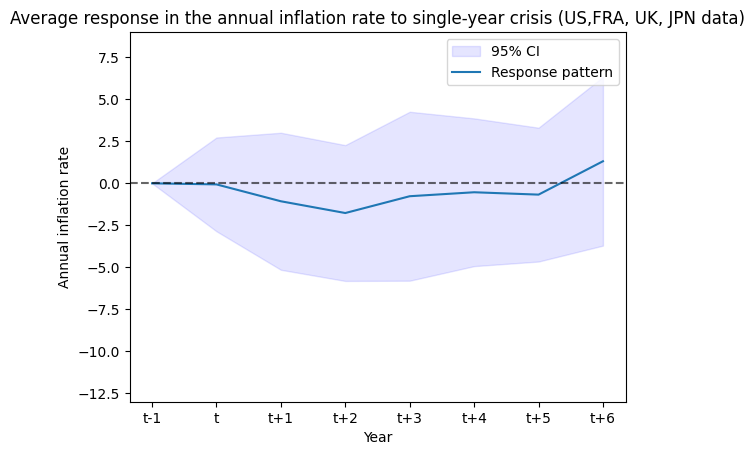

In [139]:
plt.fill_between(
    range(len(single_year_average_pattern_ALL)),
    single_year_average_pattern_ALL - single_year_confidence_interval_ALL,
    single_year_average_pattern_ALL + single_year_confidence_interval_ALL,
    color='blue',
    alpha=0.1, label='95% CI'
)

sns.lineplot(x=years, y=single_year_average_pattern_ALL, label = 'Response pattern')
plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.6)

plt.title('Average response in the annual inflation rate to single-year crisis (US,FRA, UK, JPN data)')
plt.xlabel('Year')
plt.ylabel('Annual inflation rate')

plt.ylim(-13,9)
plt.show()

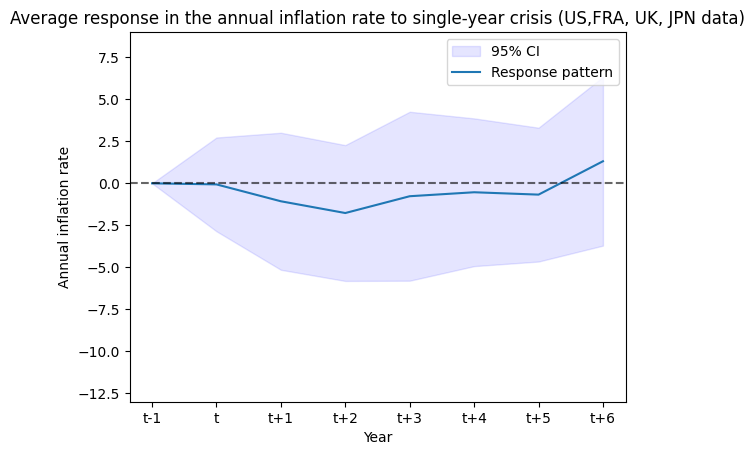

In [140]:
plt.fill_between(
    range(len(single_year_average_pattern_ALL)),
    single_year_average_pattern_ALL - single_year_confidence_interval_ALL,
    single_year_average_pattern_ALL + single_year_confidence_interval_ALL,
    color='blue',
    alpha=0.1, label='95% CI'
)

sns.lineplot(x=years, y=single_year_average_pattern_ALL, label = 'Response pattern')
plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.6)

plt.title('Average response in the annual inflation rate to single-year crisis (US,FRA, UK, JPN data)')
plt.xlabel('Year')
plt.ylabel('Annual inflation rate')

plt.ylim(-13,9)
plt.show()

* Multiyear crisis

In [141]:
# UK
UK_multi_year_crisis_duration = []
for i in range (0, len(UK_crisis_duration)):
    if UK_crisis_duration[i] >1:
        UK_multi_year_crisis_duration.append(UK_crisis_duration[i])

# France
FRA_multi_year_crisis_duration = []
for i in range (0, len(FRA_crisis_duration)):
    if FRA_crisis_duration[i] >1:
        FRA_multi_year_crisis_duration.append(FRA_crisis_duration[i])

# Japan
JPN_multi_year_crisis_duration = []
for i in range (0, len(JPN_crisis_duration)):
    if JPN_crisis_duration[i] >1:
        JPN_multi_year_crisis_duration.append(JPN_crisis_duration[i])

In [142]:
ALL_multi_year_crisis_duration = np.concatenate((multi_year_crisis_duration,
                                                UK_multi_year_crisis_duration,
                                                FRA_multi_year_crisis_duration,
                                                JPN_multi_year_crisis_duration
                                                ), axis=0)

In [143]:
#UK
multi_year_norm_inflation_series_UK = []
#Appending the series for single year crisis
for i in range (0,len(UK_norm_inflation_series)):
    if UK_crisis_duration[i] > 1:
        multi_year_norm_inflation_series_UK.append(UK_norm_inflation_series[i])
#Convert the list to a Numpy array
multi_year_norm_inflation_series_UK = np.array(multi_year_norm_inflation_series_UK)

#France
multi_year_norm_inflation_series_FRA = []
#Appending the series for single year crisis
for i in range (0,len(FRA_norm_inflation_series)):
    if FRA_crisis_duration[i] > 1:
        multi_year_norm_inflation_series_FRA.append(FRA_norm_inflation_series[i])
#Convert the list to a Numpy array
multi_year_norm_inflation_series_FRA = np.array(multi_year_norm_inflation_series_FRA)

#Japan
multi_year_norm_inflation_series_JPN = []
#Appending the series for single year crisis
for i in range (0,len(JPN_norm_inflation_series)):
    if JPN_crisis_duration[i] > 1:
        multi_year_norm_inflation_series_JPN.append(JPN_norm_inflation_series[i])
#Convert the list to a Numpy array
multi_year_norm_inflation_series_JPN = np.array(multi_year_norm_inflation_series_JPN)

In [144]:
multi_year_norm_inflation_series_ALL = np.concatenate((multi_year_norm_inflation_series,
                                                       multi_year_norm_inflation_series_UK,
                                                       multi_year_norm_inflation_series_FRA,
                                                       multi_year_norm_inflation_series_JPN
                                                       ), axis=0)

In [145]:
multi_year_weighted_average_pattern_ALL = np.average(multi_year_norm_inflation_series_ALL, axis=0, weights=ALL_multi_year_crisis_duration)
multi_year_weighted_std_ALL = np.sqrt(np.average((multi_year_norm_inflation_series_ALL - multi_year_weighted_average_pattern_ALL)**2, axis=0, weights=ALL_multi_year_crisis_duration))
multi_year_weighted_confidence_interval_ALL = 1.96 * multi_year_weighted_std_ALL / np.sqrt(sum(ALL_multi_year_crisis_duration))

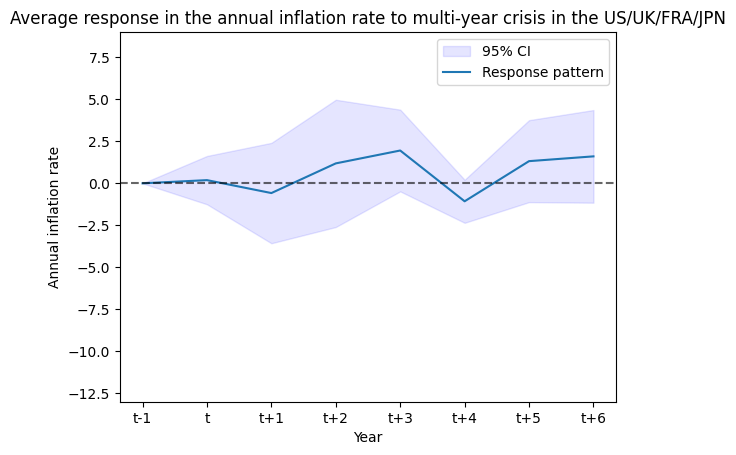

In [146]:
plt.fill_between(
    range(len(multi_year_weighted_average_pattern_ALL)),
    multi_year_weighted_average_pattern_ALL - multi_year_weighted_confidence_interval_ALL,
    multi_year_weighted_average_pattern_ALL + multi_year_weighted_confidence_interval_ALL,
    color='blue',
    alpha=0.1, label='95% CI'
)

sns.lineplot(x=years, y=multi_year_weighted_average_pattern_ALL, label = 'Response pattern')
plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.6)

plt.title('Average response in the annual inflation rate to multi-year crisis in the US/UK/FRA/JPN')
plt.xlabel('Year')
plt.ylabel('Annual inflation rate')

plt.ylim(-13,9)
plt.show()

## 6.2 In the output gap

# 7. Learning Process - First approach

In [147]:
USA_data['cum_crisis'] = USA_data['banking_crisis'].cumsum()
USA_data['row_number'] = range(1, len(USA_data) + 1)
USA_data['cum_crisis_proba'] = USA_data['cum_crisis']/USA_data['row_number']

/tmp/ipykernel_2267/2671063860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  USA_data['cum_crisis'] = USA_data['banking_crisis'].cumsum()
/tmp/ipykernel_2267/2671063860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  USA_data['row_number'] = range(1, len(USA_data) + 1)
/tmp/ipykernel_2267/2671063860.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

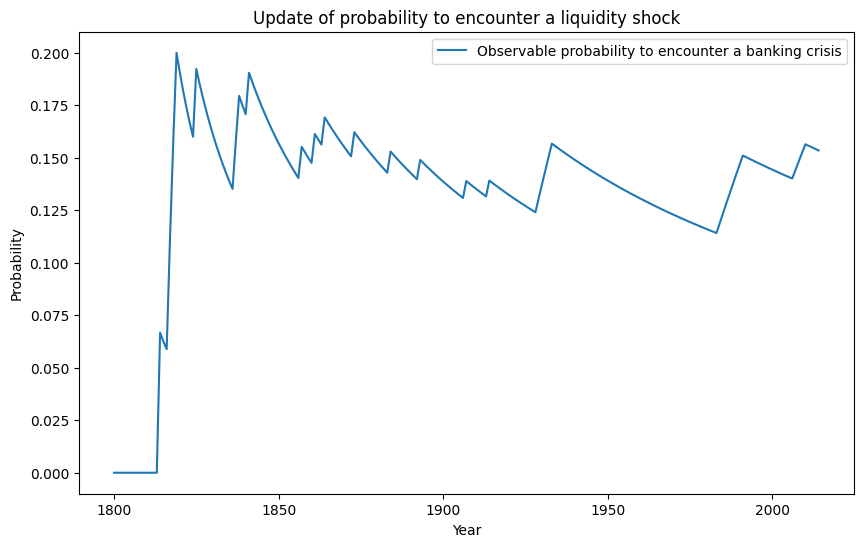

In [148]:
plt.figure(figsize=(10,6))

sns.lineplot(x=USA_data['Year'], y=USA_data['cum_crisis_proba'], label = 'Observable probability to encounter a banking crisis')

plt.title('Update of probability to encounter a liquidity shock')

plt.xlabel('Year')
plt.ylabel('Probability')
plt.legend()

# 8. What happens during crisis and recovery time? 

## 8.1 On the inflation rate side

In [167]:
def crisis_data(data, during_crisis=True):

    ''' This function is extracting the series of the annual inflation rate for each banking crisis or recovery period.
    Input:
    - dataframe
    - during_crisis = True or False (True for the series each banking crisis, False for the series of each recovery period)
    Output:
    - a list of series

    If during_crisis = True:
        The function extracts the series of the inflation rate for time [Ts-1,..., Te]
        s being the year of the beginning ot the crisis, e being the last year of the crisis.
    If during_crisis = False:
        The function extracts the series of the inflation rate for time [Te+1,..., Ts-1]
        e being the last year of the previous crisis, s being the year of the beginning ot the next crisis.
    '''

    series = []
    crisis_started = False
    no_crisis_period = False
    current_serie = []

    for index, row in data.iterrows():
        # Extract the serie only if the value of the value of the inflation rate is not a NaN value
        if not pd.isna(row['annual_inflation']):
            if during_crisis:
                # Extract data during a crisis
                if row['banking_crisis'] == 1:
                    if not crisis_started:
                        crisis_started = True
                        # Append the inflation rate for the year before the crisis
                        if index - 1 >= 0:
                            current_serie.append(data.at[index - 1, 'annual_inflation'])
                        current_serie.append(row['annual_inflation'])
                    else:
                        # Continue the existing series
                        current_serie.append(row['annual_inflation'])
                elif crisis_started:
                    # End the series when a 0 is recorded in the banking_crisis column
                    crisis_started = False
                    series.append(current_serie)
                    current_serie = []
            else:
                # Extract data during a non-crisis period
                if row['banking_crisis'] == 0:

                    if not no_crisis_period:
                        no_crisis_period = True
                        # Append the inflation rate for the current year
                        current_serie.append(row['annual_inflation'])
                    else:
                        # Continue the existing series
                        current_serie.append(row['annual_inflation'])
                elif no_crisis_period:
                    # End the series when a 0 is recorded in the banking_crisis column
                    no_crisis_period = False
                    # current_serie = np.array(current_serie)
                    series.append(current_serie)
                    # current_serie = current_serie.tolist()
                    current_serie = []
    # if not during_crisis:
    #     series = series[1:]
    return series

In [150]:
def normalize_crisis_data(list):
    normalized_list = []
    for sublist in list:
        first_element = sublist[0]
        normalized_sublist = [value - first_element for value in sublist]
        normalized_list.append(normalized_sublist)
    return normalized_list

In [151]:
def compute_pattern(list):
    max_length = max(len(sublist) for sublist in list)

    # Initialize an array for the average pattern
    pattern = np.zeros(max_length)

    # Iterate through each position in the pattern
    for i in range(max_length):
        # Initialize variables for the sum and length for each position
        col_sum = 0
        length = 0

        # Iterate through each sublist
        for sublist in list:
            # Check if the current sublist has a value at the current position
            if i < len(sublist):
                col_sum += sublist[i]
                length += 1

        # Calculate the mean for the current position
        mean = col_sum / length if length > 0 else 0

        # Set the mean in the average pattern array
        pattern[i] = mean


    return pattern

* USA example

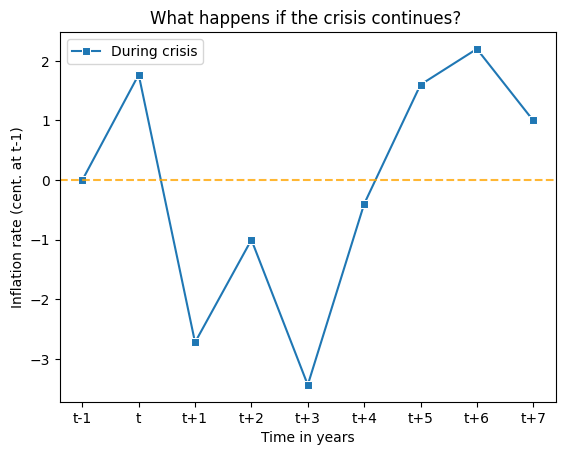

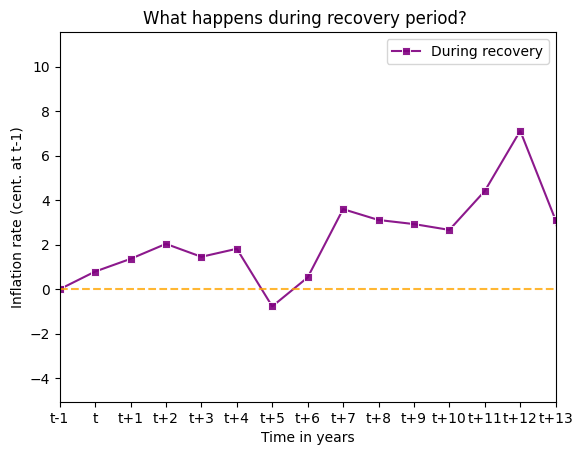

In [152]:
pattern_during_crisis = compute_pattern(normalize_crisis_data(crisis_data(USA_data, during_crisis = True)))
pattern_during_recovery = compute_pattern(normalize_crisis_data(crisis_data(USA_data, during_crisis = False)))

years = [f"t{i}" if i < 0 else f"t+{i}" if i > 0 else "t" for i in range(-1, len(pattern_during_crisis) - 1)]
sns.lineplot(x = years, y = pattern_during_crisis, marker = 's', label = 'During crisis')

plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('What happens if the crisis continues? ')

plt.xlabel('Time in years')
plt.ylabel('Inflation rate (cent. at t-1)')

plt.show()

years = [f"t{i}" if i < 0 else f"t+{i}" if i > 0 else "t" for i in range(-1, len(pattern_during_recovery) - 1)]
sns.lineplot(x = years, y = pattern_during_recovery, marker = 's', color = 'Purple', alpha = 0.9, label = 'During recovery')
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('What happens during recovery period? ')

plt.xlabel('Time in years')
plt.ylabel('Inflation rate (cent. at t-1)')
plt.xlim('t-1', 't+13')

plt.show()

* G7 countries

In [166]:
G7_inflation_series_during_crisis = []
for code in countries_selected:
    df = data[data["CC3"]==code]
    G7_inflation_series_during_crisis.extend(crisis_data(df, during_crisis = True))
pattern_during_crisis = compute_pattern(normalize_crisis_data(G7_inflation_series_during_crisis))

In [154]:
G7_inflation_series_during_recovery = []
for code in countries_selected:
    df = data[data["CC3"]==code]
    G7_inflation_series_during_recovery.extend(crisis_data(df, during_crisis = False))
pattern_during_recovery = compute_pattern(normalize_crisis_data(G7_inflation_series_during_recovery))

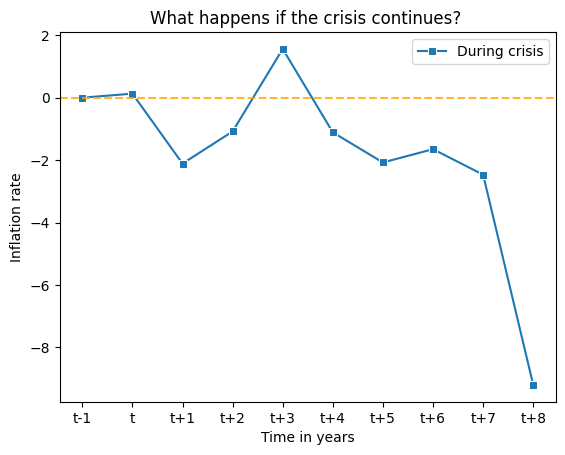

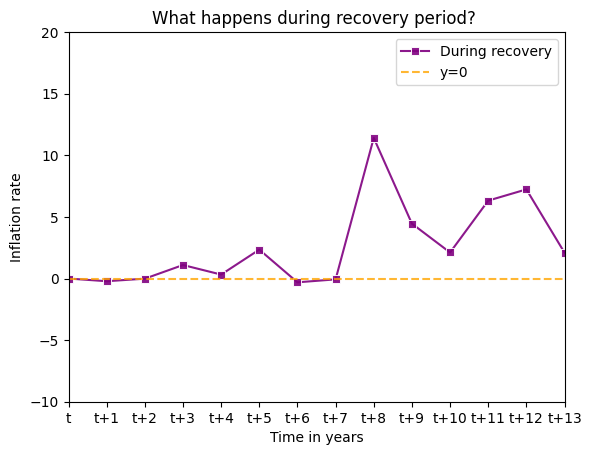

In [155]:
#Compute the average response pattern by time elapsed
# pattern_during_crisis = compute_pattern(normalize_crisis_data(crisis_data(G7_data, during_crisis = True)))
# pattern_during_recovery = compute_pattern(normalize_crisis_data(crisis_data(G7_data, during_crisis = False)))

#Plot the inflation rate during banking crsis period
years = [f"t{i}" if i < 0 else f"t+{i}" if i > 0 else "t" for i in range(-1, len(pattern_during_crisis) - 1)]
sns.lineplot(x = years, y = pattern_during_crisis, marker = 's', label = 'During crisis')

plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('What happens if the crisis continues? ')

plt.xlabel('Time in years')
plt.ylabel('Inflation rate')

plt.show()

#Plot the inflation rate during recovery period
years = [f"t{i}" if i < 0 else f"t+{i}" if i > 0 else "t" for i in range(0, len(pattern_during_recovery))]
sns.lineplot(x = years, y = pattern_during_recovery, marker = 's', color = 'Purple', alpha = 0.9, label = 'During recovery')
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('What happens during recovery period? ')

plt.xlabel('Time in years')
plt.ylabel('Inflation rate')
plt.ylim(-10, 20)
plt.xlim('t', 't+13')
plt.legend()

plt.show()

In [156]:
length_counts = {}
for sublist in crisis_data(G7_data, during_crisis = True):
    length = len(sublist)
    if length in length_counts:
        length_counts[length] += 1
    else:
        length_counts[length] = 1

# Convert dictionary to pandas DataFrame
df = pd.DataFrame(list(length_counts.items()), columns=['Length', 'Count'])

# Sort DataFrame by length
df = df.sort_values(by='Length')
df.reset_index(drop=True, inplace=True)
print(df)

   Length  Count
0       2     36
1       3     15
2       4      8
3       5      4
4       6      1
5       7      2
6       8      3
7       9      2
8      10      1


## 8.2 On the output gap side

In [157]:
def create_output_df(data, code):
    df = data.loc[data['Code'] == code]
    cycle, trend = sm.tsa.filters.hpfilter(df.GDP_per_capita, lamb=1600)
    dataframe = pd.DataFrame({
    'CC3': df.Code,
    'Year' : df.Year,
    'output_gap' : round(((df.GDP_per_capita - trend)/trend)*100, 2)})
    return dataframe

In [158]:
def merge_datasets(dataset1, dataset2, on=['Year', 'CC3'], how='inner'):
    merged_df = pd.merge(dataset1, dataset2, on=on, how=how)
    return merged_df

In [159]:
def output_crisis_data(data, during_crisis=True):
    ''' This function is extracting the series of the annual inflation rate for each banking crisis or recovery period.
    Input:
    - dataframe
    - during_crisis = True or False (True for the series each banking crisis, False for the series of each recovery period)
    Output:
    - a list of series

    If during_crisis = True:
        The function extracts the series of the inflation rate for time [Ts-1,..., Te]
        s being the year of the beginning ot the crisis, e being the last year of the crisis.
    If during_crisis = False:
        The function extracts the series of the inflation rate for time [Te+1,..., Ts-1]
        e being the last year of the previous crisis, s being the year of the beginning ot the next crisis.
    '''
    series = []
    crisis_started = False
    no_crisis_period = False
    current_serie = []

    for index, row in data.iterrows():
        # Extract the serie only if the value of the value of the inflation rate is not a NaN value
        if not pd.isna(row['output_gap']):
            if during_crisis:
                # Extract data during a crisis
                if row['banking_crisis'] == 1:
                    if not crisis_started:
                        crisis_started = True
                        # Append the inflation rate for the year before the crisis
                        if index - 1 >= 0:
                            current_serie.append(data.at[index - 1, 'output_gap'])
                        current_serie.append(row['output_gap'])
                    else:
                        # Continue the existing series
                        current_serie.append(row['output_gap'])
                elif crisis_started:
                    # End the series when a 0 is recorded in the banking_crisis column
                    crisis_started = False
                    series.append(current_serie)
                    current_serie = []
            else:
                # Extract data during a non-crisis period
                if row['banking_crisis'] == 0:

                    if not no_crisis_period:
                        no_crisis_period = True
                        # Append the inflation rate for the current year
                        current_serie.append(row['output_gap'])
                    else:
                        # Continue the existing series
                        current_serie.append(row['output_gap'])
                elif no_crisis_period:
                    # End the series when a 0 is recorded in the banking_crisis column
                    no_crisis_period = False
                    # current_serie = np.array(current_serie)
                    series.append(current_serie)
                    # current_serie = current_serie.tolist()
                    current_serie = []
    # if not during_crisis:
    #     series = series[1:]
    return series

* US example

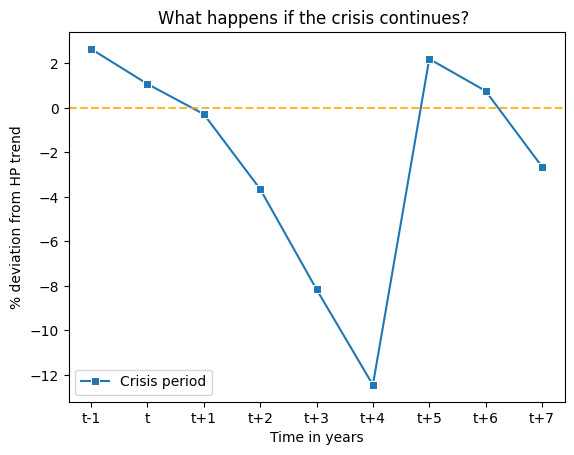

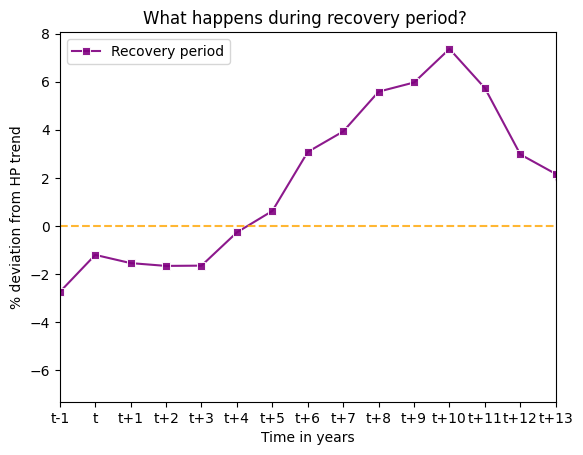

In [160]:
USA_output_data = merge_datasets(create_output_df(GDP_pc, 'USA'), USA_data)
pattern_during_crisis = compute_pattern(output_crisis_data(USA_output_data, during_crisis = True))
pattern_during_recovery = compute_pattern(output_crisis_data(USA_output_data, during_crisis = False))

years = [f"t{i}" if i < 0 else f"t+{i}" if i > 0 else "t" for i in range(-1, len(pattern_during_crisis) - 1)]
sns.lineplot(x = years, y = pattern_during_crisis, marker = 's', label = 'Crisis period')

plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('What happens if the crisis continues? ')

plt.xlabel('Time in years')
plt.ylabel('% deviation from HP trend')

plt.show()

years = [f"t{i}" if i < 0 else f"t+{i}" if i > 0 else "t" for i in range(-1, len(pattern_during_recovery) - 1)]
sns.lineplot(x = years, y = pattern_during_recovery, marker = 's', color = 'Purple', alpha = 0.9, label = 'Recovery period')
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('What happens during recovery period? ')

plt.xlabel('Time in years')
plt.ylabel('% deviation from HP trend')
plt.xlim('t-1', 't+13')

plt.show()

* G7 countries

In [161]:
G7_outputgap_series_during_crisis = []
for code in countries_selected:
    df = merge_datasets(create_output_df(GDP_pc, code), data[data["CC3"]==code])
    G7_outputgap_series_during_crisis.extend(output_crisis_data(df, during_crisis = True))
pattern_during_crisis = compute_pattern(G7_outputgap_series_during_crisis)

In [162]:
G7_outputgap_series_during_recovery = []
for code in countries_selected:
    df = merge_datasets(create_output_df(GDP_pc, code), data[data["CC3"]==code])
    G7_outputgap_series_during_recovery.extend(output_crisis_data(df, during_crisis = False))
pattern_during_recovery = compute_pattern(G7_outputgap_series_during_recovery)

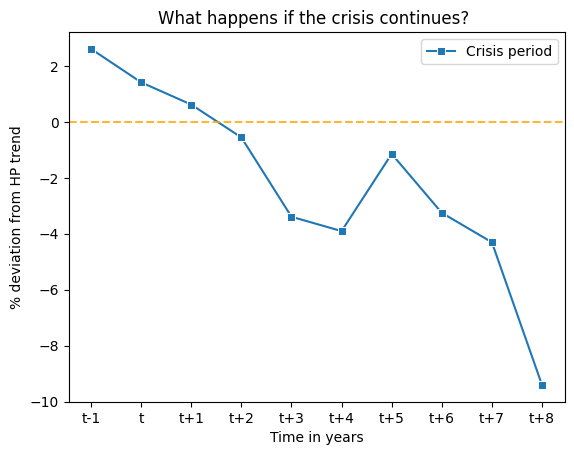

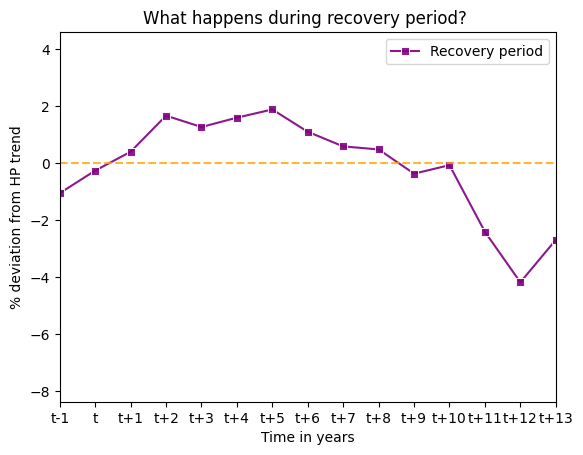

In [163]:
# pattern_during_crisis = compute_pattern(output_crisis_data(G7_output_data, during_crisis = True))
# pattern_during_recovery = compute_pattern(output_crisis_data(G7_output_data, during_crisis = False))

years = [f"t{i}" if i < 0 else f"t+{i}" if i > 0 else "t" for i in range(-1, len(pattern_during_crisis) - 1)]
sns.lineplot(x = years, y = pattern_during_crisis, marker = 's', label = 'Crisis period')

plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('What happens if the crisis continues? ')

plt.xlabel('Time in years')
plt.ylabel('% deviation from HP trend')

plt.show()

years = [f"t{i}" if i < 0 else f"t+{i}" if i > 0 else "t" for i in range(-1, len(pattern_during_recovery) - 1)]
sns.lineplot(x = years, y = pattern_during_recovery, marker = 's', color = 'Purple', alpha = 0.9, label = 'Recovery period')
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('What happens during recovery period? ')

plt.xlabel('Time in years')
plt.ylabel('% deviation from HP trend')
plt.xlim('t-1', 't+13')

plt.show()